In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# The Data

In [3]:
data = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')
data = data.dropna(subset = ['new_deaths'])

# converting date to date object
data['date'] = pd.to_datetime(data['date'])

# dropping observations before COVID-19 was detected in the country
data = data[~data['total_cases'].isna()]

# dropping redundant columns like smoothed and similar predictors
columns_to_drop = ['new_cases_smoothed',
                   'new_cases_smoothed_per_million',
                   'total_deaths',
                   'total_deaths_per_million',
                   'new_deaths_per_million',
                   'new_deaths_smoothed',
                   'new_deaths_smoothed_per_million',
                   'excess_mortality_cumulative',
                   'excess_mortality_cumulative_absolute',
                   'excess_mortality_cumulative_per_million',
                   'icu_patients',
                   'hosp_patients',
                   'weekly_icu_admissions',
                   'weekly_hosp_admissions',
                   'total_tests',
                   'new_tests',
                   'new_tests_smoothed',
                   'new_tests_smoothed_per_thousand',
                   'tests_per_case', #this is the inverse of positive_rate
                   'new_vaccinations_smoothed',
                   'total_vaccinations',
                   'people_vaccinated',
                   'people_fully_vaccinated',
                   'total_boosters',
                   'new_vaccinations_smoothed_per_million',
                   'new_people_vaccinated_smoothed']
data = data.drop(columns_to_drop,axis=1)

# filtering countries by null values in other columns
null_counts = data.groupby('location').agg(lambda x: x.isnull().sum(axis=0))
# missing_counts = data.groupby('location').apply(lambda x: x.isnull().sum())
total_null = null_counts.sum(axis=1)
null_counts['total_null'] = null_counts.sum(axis=1)
#filtering top 10 countries 
sorted_countries = null_counts[['total_null']].sort_values(by = 'total_null',ascending=True)
top_df = sorted_countries.iloc[:10]
filtered_countries_list = top_df.index.to_list()
data = data[data['location'].isin(filtered_countries_list)]
print(data.shape)
total_missing_per_country = total_null
sorted_countries = total_missing_per_country.sort_values(ascending=True)
sorted_countries.head(10)

(2007, 41)


location
United States    1008
Estonia          1104
Italy            1191
Ireland          1285
Israel           1367
Czechia          1408
Malaysia         1465
Belgium          1514
Chile            1559
France           1583
dtype: int64

# Missingness

In [4]:
# filtering data for top 10 countries with least missingness
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result_df = pd.DataFrame()
    for country in data['location'].unique():
        country_data = data[data['location'] == country]
        missing_counts = country_data.isnull().sum()
        total_missing = missing_counts.sum()
        missingness_prop = total_missing / (len(country_data)*data.shape[1])
        result_df = result_df.append({'location': country, 'total_missing': total_missing, 'missingness_prop': missingness_prop}, ignore_index=True)
    
    sorted_countries = result_df.sort_values(by='missingness_prop', ascending=False)
    print(sorted_countries.head(10))

        location  total_missing  missingness_prop
1          Chile           1559          0.189176
4         France           1583          0.186521
0        Belgium           1514          0.180131
8       Malaysia           1465          0.172617
2        Czechia           1408          0.170853
6         Israel           1367          0.163439
5        Ireland           1285          0.155928
9  United States           1008          0.142112
7          Italy           1191          0.141013
3        Estonia           1104          0.133301


In [5]:
# shrinking the original data set based on top 10 countries

top_countries = sorted_countries.head(10)
data_smaller = data[data['location'].isin(top_countries['location'])]

In [6]:
# looking at missingness in the smaller dataset

missing_values = data_smaller.isnull().sum()
missingness_prop = missing_values / len(data_smaller)
column_missingness = missing_values.to_frame(name='total_missing').join(missingness_prop.rename('missingness_prop')).sort_values(by='missingness_prop',ascending=False)

def highlight(val):
    color = 'red' if val > 0.5 else 'default'
    return f'color: {color}'

column_missingness = column_missingness.style.applymap(highlight, subset=['missingness_prop'])
column_missingness

,total_missing,missingness_prop
handwashing_facilities,2007,1.000000
total_boosters_per_hundred,996,0.496263
positive_rate,832,0.414549
new_tests_per_thousand,825,0.411061
total_tests_per_thousand,825,0.411061
tests_units,825,0.411061
weekly_icu_admissions_per_million,781,0.389138
new_vaccinations,764,0.380668
people_fully_vaccinated_per_hundred,735,0.366218
people_vaccinated_per_hundred,733,0.365222


## Missingness Comments
columns with missingness over 0.50, which we have decided warrants a closer look are total_boosters (51% missing), total_boosters_per_hundred (51% missing), and hand_washing_facilities (100% missing). Based on correlation with the target variable, if those columns have low correlation, we will remove them from the data set. 

# Constant Variables

In [7]:
# looking for constant and quasi-constant variables
num_col = data_smaller.select_dtypes(include=['number']).columns
data_num = data_smaller[num_col]
threshold = 0.95
selector = VarianceThreshold(threshold)
selector.fit(data_num)
quasi_constant_indices = data_num.columns[~selector.get_support()]
quasi_constant_indices

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Index(['reproduction_rate', 'positive_rate',
       'new_people_vaccinated_smoothed_per_hundred', 'extreme_poverty',
       'handwashing_facilities', 'human_development_index'],
      dtype='object')

## Correlation Comments
The quasi-constant variables are reproduction_rate, positive_rate, extreme_poverty, handwashing_facilities, and human_development_index. These should be removed from the dataset.

# Correlation

In [8]:
# the correlation matrix
corr = pd.DataFrame(np.abs(data.corrwith(data["new_deaths"])).sort_values(ascending=False))
corr = corr.rename(columns={0: 'Correlation with new_deaths'})
corr.style.applymap(highlight)

,Correlation with new_deaths
new_deaths,1.000000
population,0.711513
new_cases,0.642166
new_vaccinations,0.548846
weekly_icu_admissions_per_million,0.461244
male_smokers,0.372662
total_cases,0.350927
icu_patients_per_million,0.338267
weekly_hosp_admissions_per_million,0.305290
excess_mortality,0.300388


## Correlation Comments
The table above has correlations over 0.50 highlighted, but the strongest correlations with total_deaths are the ones over 0.70. These include total_cases (0.96), total_tests (0.98), new_tests (0.70), otal_vaccinations (0.98), people_vaccinated (0.98), people_fully_vaccinated (0.97), total_boosters (0.75), population (0.87), and excess_mortality_cumulative_absolute	(0.99).

In [9]:
corr['missingness_prop'] = missingness_prop
corr['low correlation/high missingness'] = (1-corr['Correlation with new_deaths'])*missingness_prop
corr.sort_values(by='low correlation/high missingness', ascending=False).style.applymap(highlight)

,Correlation with new_deaths,missingness_prop,low correlation/high missingness
new_tests_per_thousand,0.031820,0.411061,0.397981
total_tests_per_thousand,0.042468,0.411061,0.393604
positive_rate,0.068776,0.414549,0.386038
total_boosters_per_hundred,0.250674,0.496263,0.371863
people_vaccinated_per_hundred,0.198599,0.365222,0.292689
people_fully_vaccinated_per_hundred,0.220114,0.366218,0.285609
total_vaccinations_per_hundred,0.217326,0.363229,0.284290
new_people_vaccinated_smoothed_per_hundred,0.115379,0.315894,0.279447
reproduction_rate,0.104465,0.265072,0.237382
weekly_icu_admissions_per_million,0.461244,0.389138,0.209650


In the above table, we calculate features with low correlation with the target variable and high missingness. Since 'new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred' have low correlation with the target variable and high missingness, we will remove them. 

# Final Dataset Edits

In [10]:
# removing the columns specified above
features_to_remove = quasi_constant_indices.to_list()
features_to_remove.extend(['new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred'])
data = data.drop(features_to_remove, axis=1, errors='ignore')
data.shape
df = data

In [11]:
df.describe()

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
count,2.007000e+03,2.007000e+03,2007.000000,2007.000000,2007.000000,1641.000000,1600.000000,1226.000000,1767.000000,1.243000e+03,...,2007.00000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2.007000e+03,1667.000000
mean,9.011689e+06,9.784317e+04,844.764325,208375.428590,1977.096282,20.104205,134.513453,9.110152,92.965997,5.569120e+04,...,10.34805,38017.226212,155.636553,7.025874,22.264375,34.345441,3.901689,80.668137,5.151598e+07,9.743845
std,1.870686e+07,3.120448e+05,2473.030330,182302.530431,4152.403407,27.966537,137.851544,13.136121,99.951098,1.416603e+05,...,3.67124,12680.273880,63.876776,3.911759,9.040146,6.091309,1.623385,2.254464,9.077861e+07,14.588481
min,1.000000e+00,0.000000e+00,0.000000,0.021000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,3.40700,22767.037000,86.060000,3.280000,1.000000,24.600000,1.900000,76.160000,1.326064e+06,-20.600000
25%,4.747540e+05,1.540000e+03,14.000000,41577.192000,160.102500,2.787000,37.679500,1.270000,27.501500,2.115000e+02,...,7.35900,29481.252000,113.151000,4.290000,19.100000,27.800000,2.770000,78.860000,9.449000e+06,0.690000
50%,2.267099e+06,1.089900e+04,64.000000,148611.995000,655.997000,8.361000,85.504500,3.811000,63.636000,2.518000e+03,...,11.58000,33132.320000,126.459000,4.780000,24.500000,35.600000,3.180000,81.630000,1.165592e+07,6.730000
75%,5.024992e+06,5.122600e+04,394.500000,394109.788000,1987.402500,27.025000,184.063500,11.221000,120.076500,2.999100e+04,...,13.07900,42658.576000,227.485000,8.460000,30.100000,39.300000,5.640000,82.660000,5.903747e+07,14.495000
max,1.034368e+08,5.650933e+06,23312.000000,603427.621000,52358.239000,174.290000,840.672000,86.565000,703.736000,1.402874e+06,...,16.24000,67335.293000,260.942000,16.740000,34.200000,42.400000,6.630000,83.510000,3.382899e+08,105.350000


# The Target Variable: total_deaths

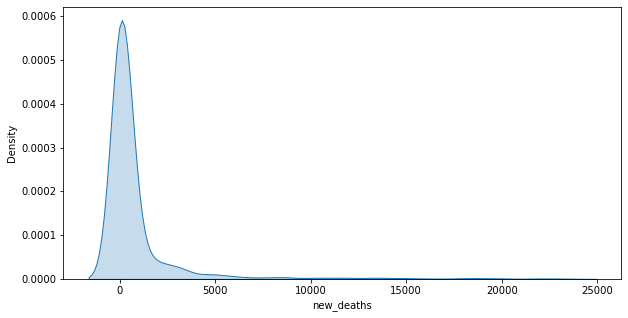

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='new_deaths', fill=True, label='Density Plot')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 720x360 with 0 Axes>

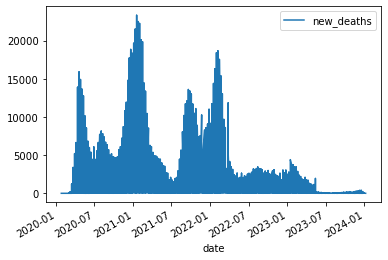

In [13]:
plt.figure(figsize=(10,5))
df.plot.line(x='date',y='new_deaths')
plt.show

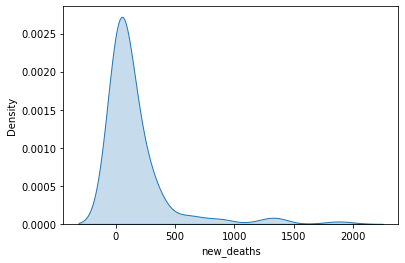

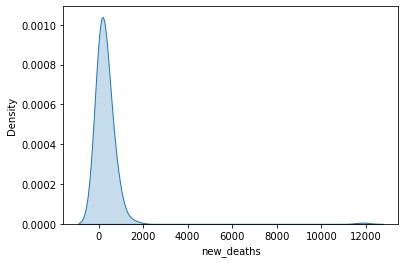

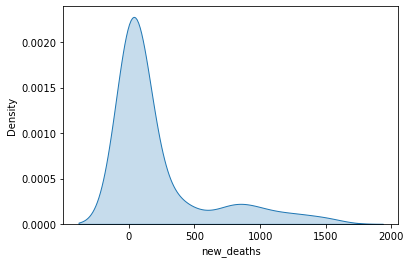

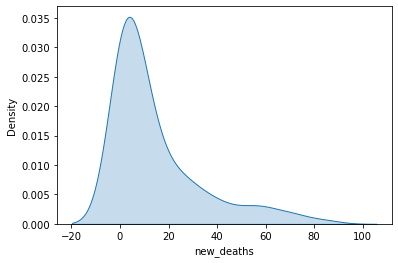

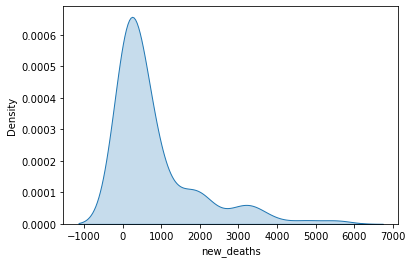

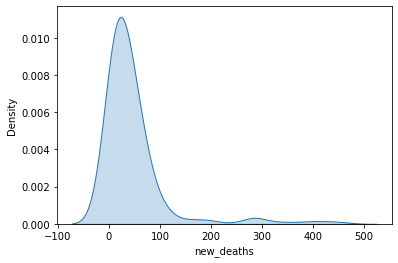

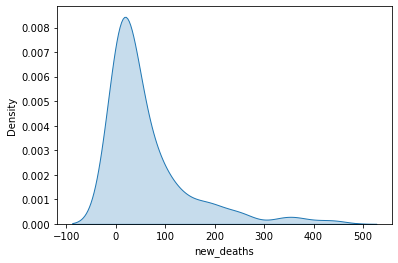

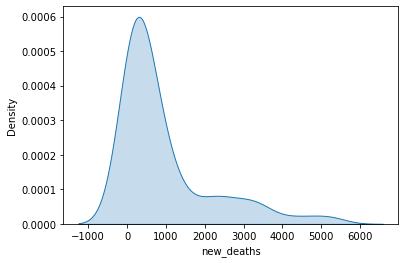

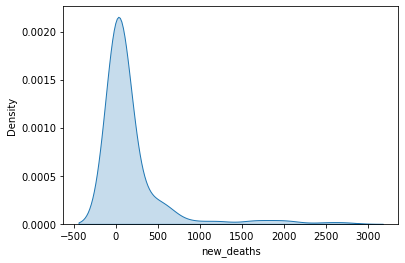

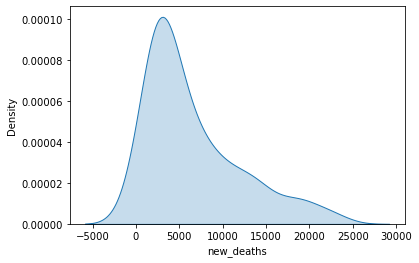

In [14]:
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    sns.kdeplot(data=country_data, x='new_deaths', fill=True)
    plt.show()

# The (Numeric) Predictors

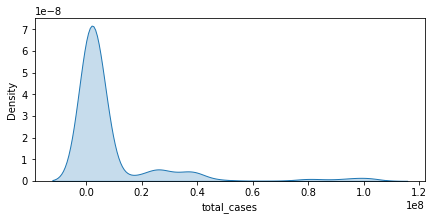

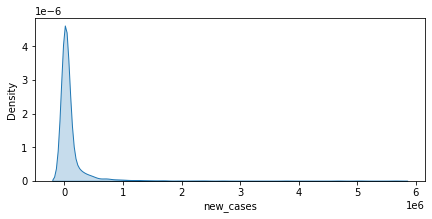

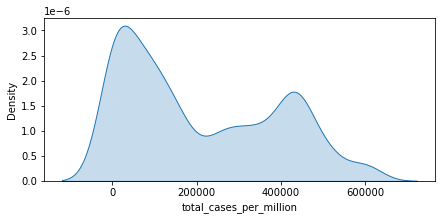

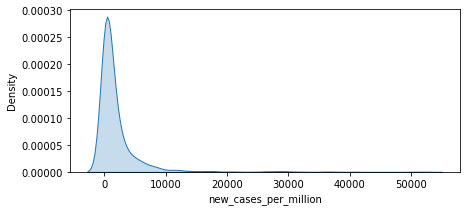

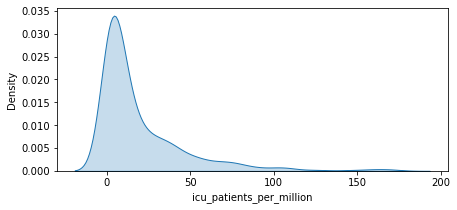

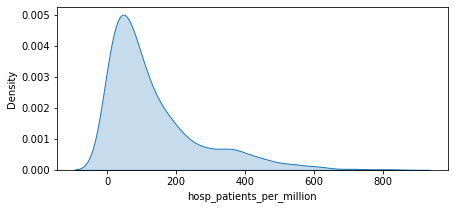

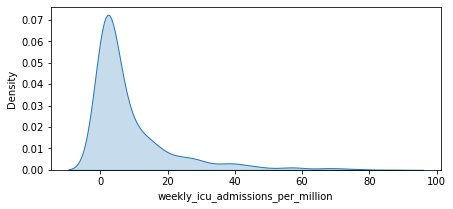

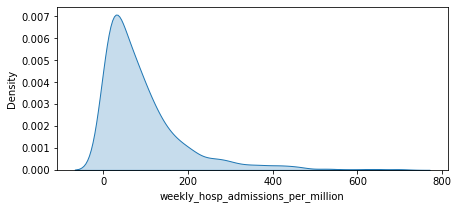

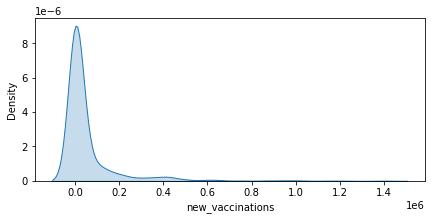

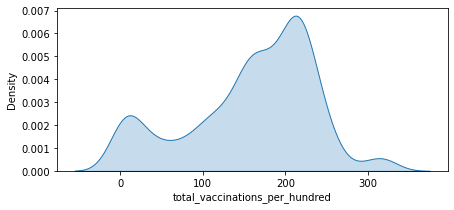

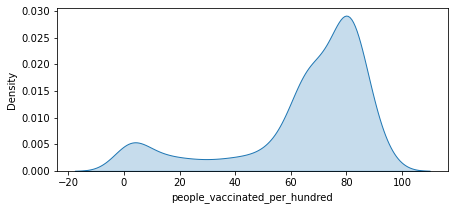

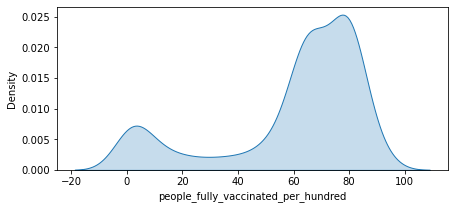

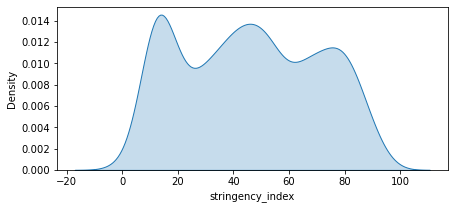

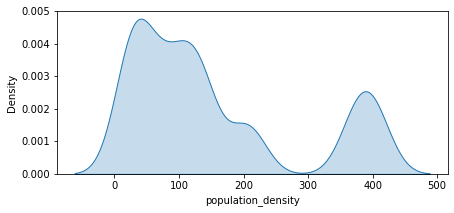

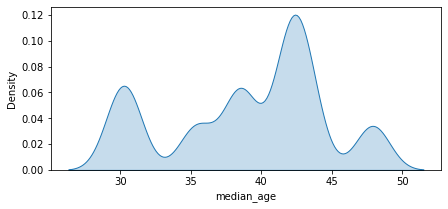

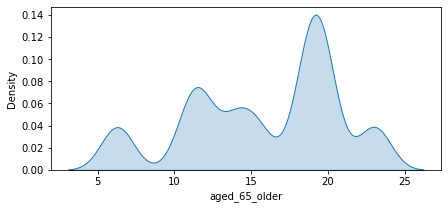

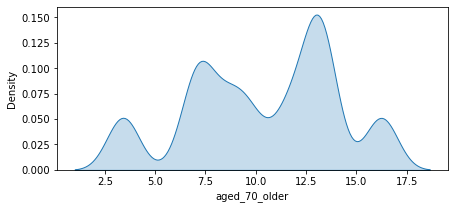

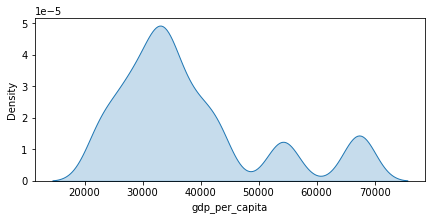

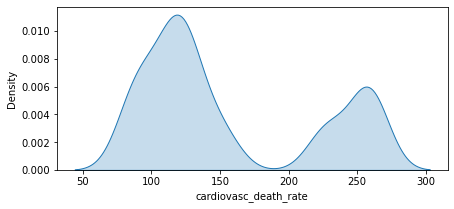

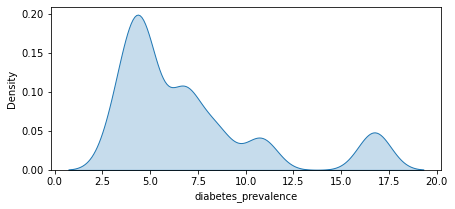

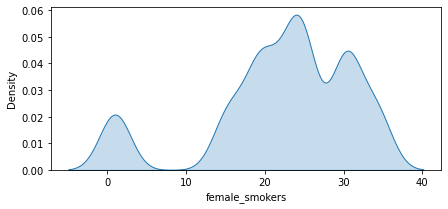

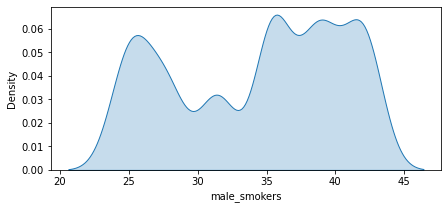

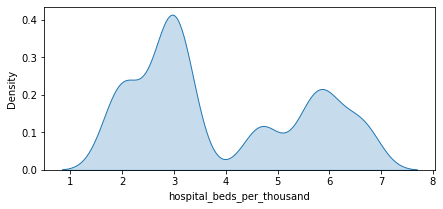

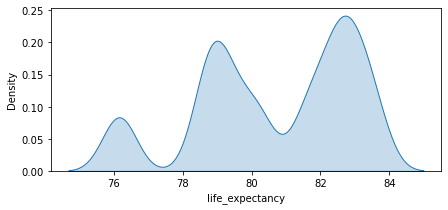

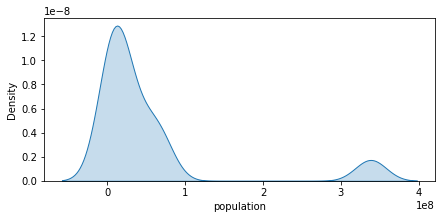

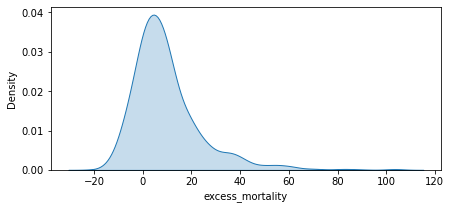

In [15]:
num_var = df.select_dtypes(include=['float64', 'int64']).columns
nontarget = [var for var in num_var if var != 'new_deaths']

for var in nontarget:
    plt.figure(figsize=(7,3))
    sns.kdeplot(data=df, x=var, fill=True)
    plt.show()



# Correlations Among Predictors

In [16]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
total_cases,1.000000,0.415566,0.350927,0.301492,0.022055,-0.064028,-0.023003,-0.117564,0.000078,0.252131,0.194886,0.229564,0.159741,-0.198333,-0.175981,0.096562,0.126015,0.109441,0.255262,-0.162831,0.145794,-0.016245,-0.382249,-0.062030,-0.024303,0.717038,-0.067415
new_cases,0.415566,1.000000,0.642166,-0.015104,0.413433,0.229137,0.279345,0.203255,0.320505,0.366236,-0.000612,0.033475,0.001586,0.004288,-0.131390,0.057125,0.076106,0.064293,0.189489,-0.101519,0.112741,-0.019940,-0.276843,-0.058448,-0.034374,0.519759,0.176917
new_deaths,0.350927,0.642166,1.000000,-0.168407,0.092862,0.338267,0.287799,0.461244,0.305290,0.548846,-0.217326,-0.198599,-0.220114,0.214413,-0.196253,0.034489,0.044958,0.028764,0.262575,-0.069508,0.192331,-0.052617,-0.372662,-0.136501,-0.119298,0.711513,0.300388
total_cases_per_million,0.301492,-0.015104,-0.168407,1.000000,0.037945,-0.390395,-0.088426,-0.343057,-0.110857,-0.296158,0.605222,0.497624,0.532659,-0.722232,0.150144,0.165171,0.236417,0.225759,0.006636,-0.120780,-0.267859,0.180625,-0.027888,0.266565,0.216691,-0.098368,-0.233509
new_cases_per_million,0.022055,0.413433,0.092862,0.037945,1.000000,0.230647,0.473047,0.272852,0.515201,0.009609,0.048575,0.047830,0.056020,-0.084783,0.052592,0.073361,0.103265,0.099840,0.012798,-0.064790,-0.103776,0.070042,-0.031484,0.097277,0.094767,-0.008098,0.219431
icu_patients_per_million,-0.064028,0.229137,0.338267,-0.390395,0.230647,1.000000,0.846243,0.949422,0.659606,0.155658,-0.525898,-0.509615,-0.527436,0.558340,-0.068072,0.045905,0.043692,0.031633,-0.058985,-0.148340,-0.044318,0.278590,0.035706,0.079403,0.043489,0.099993,0.644168
hosp_patients_per_million,-0.023003,0.279345,0.287799,-0.088426,0.473047,0.846243,1.000000,0.860815,0.838552,0.088787,-0.401823,-0.455598,-0.416032,0.289426,-0.019565,0.246702,0.282201,0.276532,-0.064967,-0.115569,-0.171075,0.257755,0.001901,0.262144,0.131212,0.039882,0.642528
weekly_icu_admissions_per_million,-0.117564,0.203255,0.461244,-0.343057,0.272852,0.949422,0.860815,1.000000,0.738604,0.050300,-0.504981,-0.525514,-0.519597,0.493872,-0.144747,0.012808,-0.012924,-0.029565,-0.218588,0.004651,0.240824,0.332332,0.261046,0.109269,-0.135979,0.124547,0.639027
weekly_hosp_admissions_per_million,0.000078,0.320505,0.305290,-0.110857,0.515201,0.659606,0.838552,0.738604,1.000000,0.153584,-0.381385,-0.401141,-0.376147,0.222615,-0.099141,0.047927,0.046289,0.023948,-0.025598,0.147722,0.049380,0.046926,0.052625,0.128311,-0.140561,0.091441,0.644117
new_vaccinations,0.252131,0.366236,0.548846,-0.296158,0.009609,0.155658,0.088787,0.050300,0.153584,1.000000,-0.270374,-0.179020,-0.253433,0.327924,-0.132133,0.000153,0.008878,0.000797,0.214583,-0.061808,0.216994,-0.155412,-0.338261,-0.195513,-0.090773,0.587191,0.065391


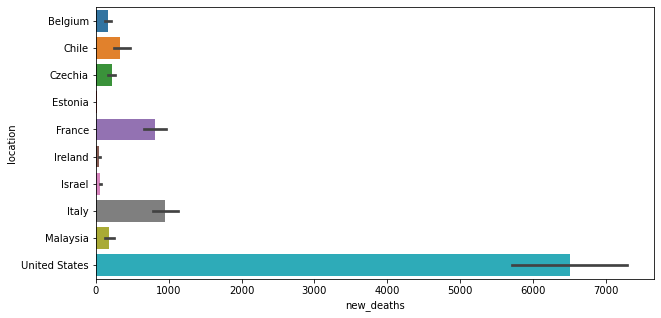

In [17]:
# Outliers Visualization

plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='new_deaths', y="location", fill=True, label='Density Plot')
plt.show()

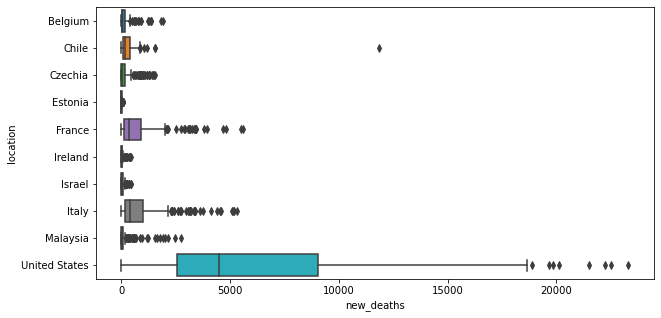

In [18]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_deaths', y="location")
plt.show()

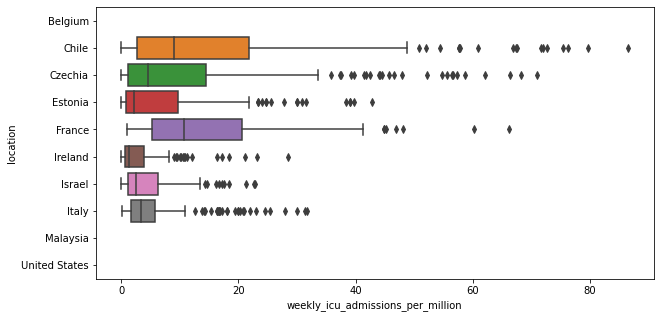

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='weekly_icu_admissions_per_million', y="location")
plt.show()

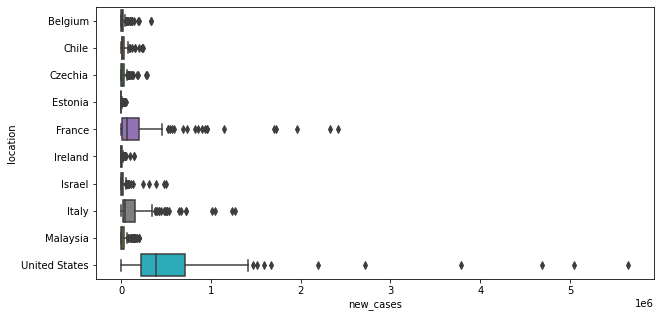

In [20]:
#new cases
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_cases', y="location")
plt.show()

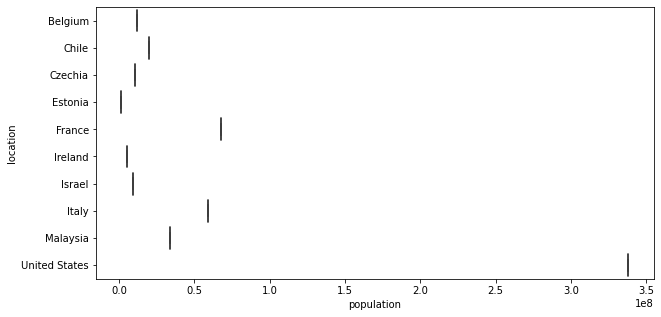

In [21]:
# is this visualization necessary?

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='population', y="location")
plt.show()

# Correlation Analysis

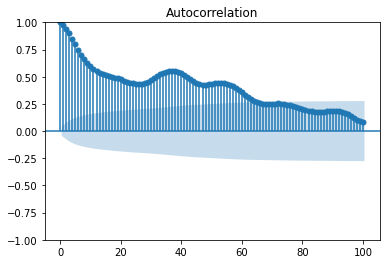

In [22]:
plot_acf(df['new_deaths'], lags = 100)
plt.show()

There seems to be significant correlation (strong, positive correlation) for all lag values

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


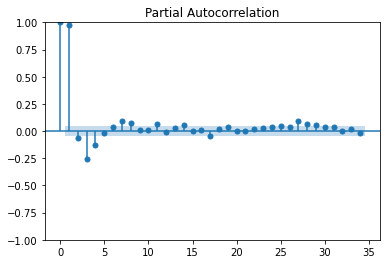

In [23]:
plot_pacf(df['new_deaths'])
plt.show()

The first couple of lags indicate a very strong correlation, though it changes from positive to negative. The rest of the lags are usually within the confidence interval, meaning a weaker correlation, though there may be an underlying pattern of seasonality to explore.

In [24]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [25]:
check_stationarity(df['new_deaths'])

ADF Statistic: -3.497720
p-value: 0.008046
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


The sample data is stationary. Therefore, we do not need to difference the time series.

## Seasonal Decomposition

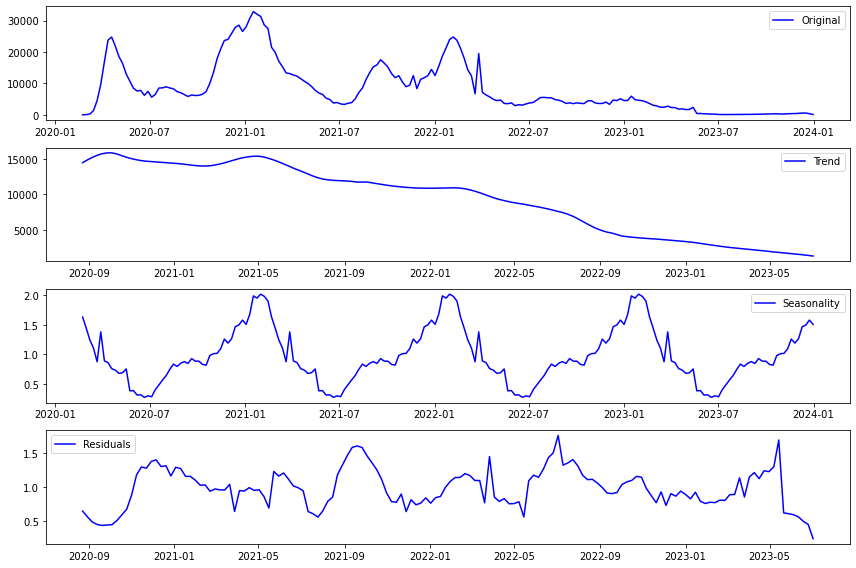

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

## seasonality aggregated by day

from statsmodels.tsa.seasonal import seasonal_decompose
grouped_death = df[['date','new_deaths']].groupby('date').sum()
grouped_death = grouped_death[grouped_death['new_deaths']!=0]
decomposition = seasonal_decompose(grouped_death, model='multiplicative', period=52) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(grouped_death['new_deaths'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

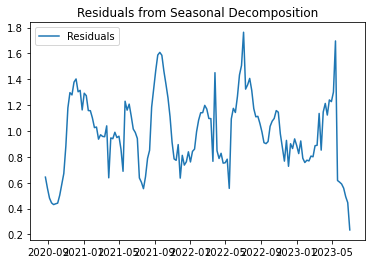

Statistics=0.553, p=0.758
Residuals look Gaussian (fail to reject H0)


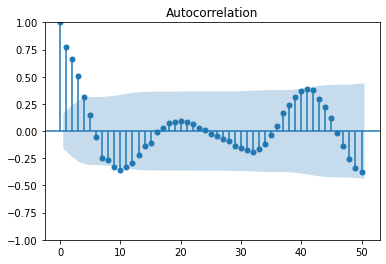

In [27]:
residuals = decomposition.resid.dropna()  

plt.figure()
plt.plot(residuals, label='Residuals')
plt.legend(loc='best')
plt.title('Residuals from Seasonal Decomposition')
plt.show()

# Statistical tests on residuals
from scipy.stats import normaltest
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretation
alpha = 0.05
if p > alpha:
    print('Residuals look Gaussian (fail to reject H0)')
else:
    print('Residuals do not look Gaussian (reject H0)')

# Checking for autocorrelation in residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=50)
plt.show()

The residuals plot shows that there are fluctuations over time without a clear or consistent pattern, suggesting that the data has been appropriately de-seasonalized.

The normality test reports a statistic of -0.553 with a p-value of 0.758. Since the p-value is well above the common alpha level of 0.05, we fail to reject the null hypothesis, which means there is not enough evidence to say the residuals are not normally distributed. This is a good sign, as it suggests that the residuals, which represent the noise or error of the seasonal decomposition, do not have any systematic structure that could be modeled.

The second plot displays the autocorrelation of these residuals. Ideally, if all temporal dependencies have been accounted for in the decomposition, the autocorrelation values should fall within the blue shaded area, which represents the confidence interval for the autocorrelation being zero (no autocorrelation). Here, several points fall outside of the confidence interval, particularly at the first few lags, indicating some degree of autocorrelation in the residuals. This could suggest there's still some temporal structure not captured by the decomposition.

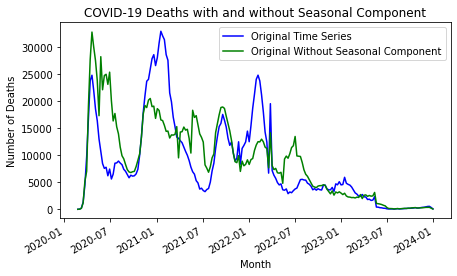

In [28]:
# Plotting the original data and original data without the seasonal component
plt.figure(figsize=(7, 4))
# Plot the original time series data
plt.plot(grouped_death, label='Original Time Series', color='blue')
data_without_seasonal = grouped_death['new_deaths'] / decomposition.seasonal
plt.plot(data_without_seasonal, label='Original Without Seasonal Component', color='green')
# Plot the original data without the seasonal component
plt.title('COVID-19 Deaths with and without Seasonal Component')
plt.xlabel('Month')
plt.ylabel('Number of Deaths')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Multivariate Analysis

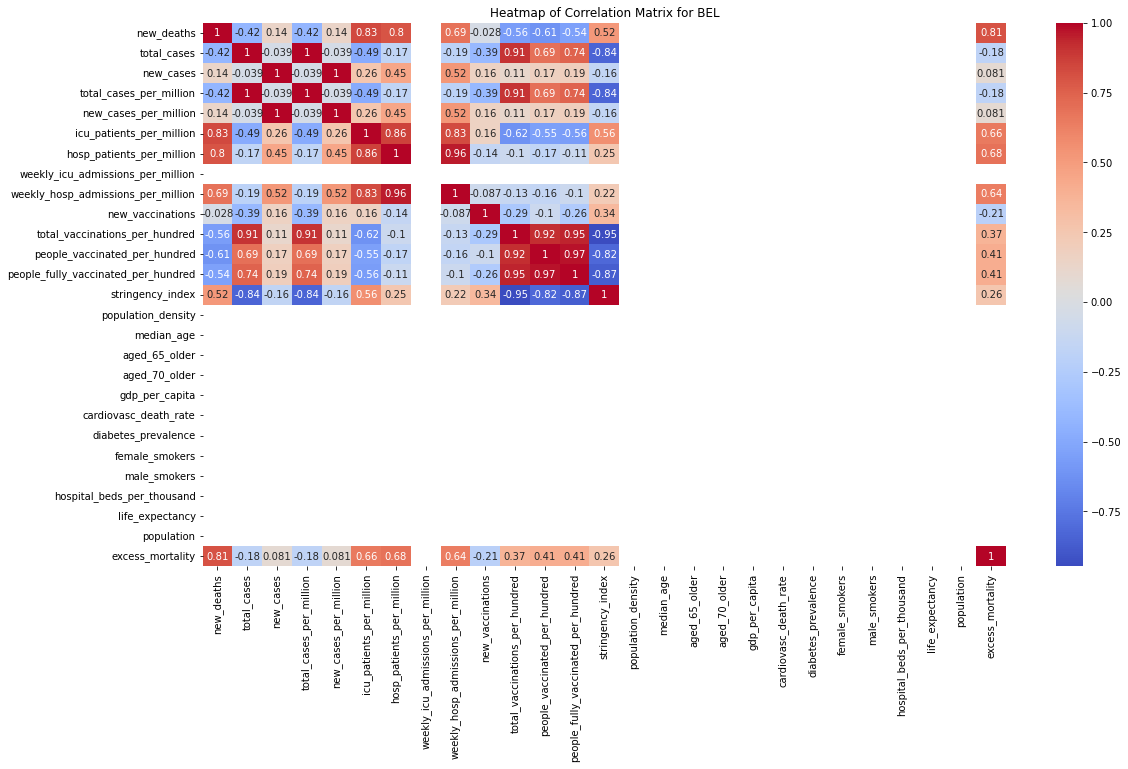

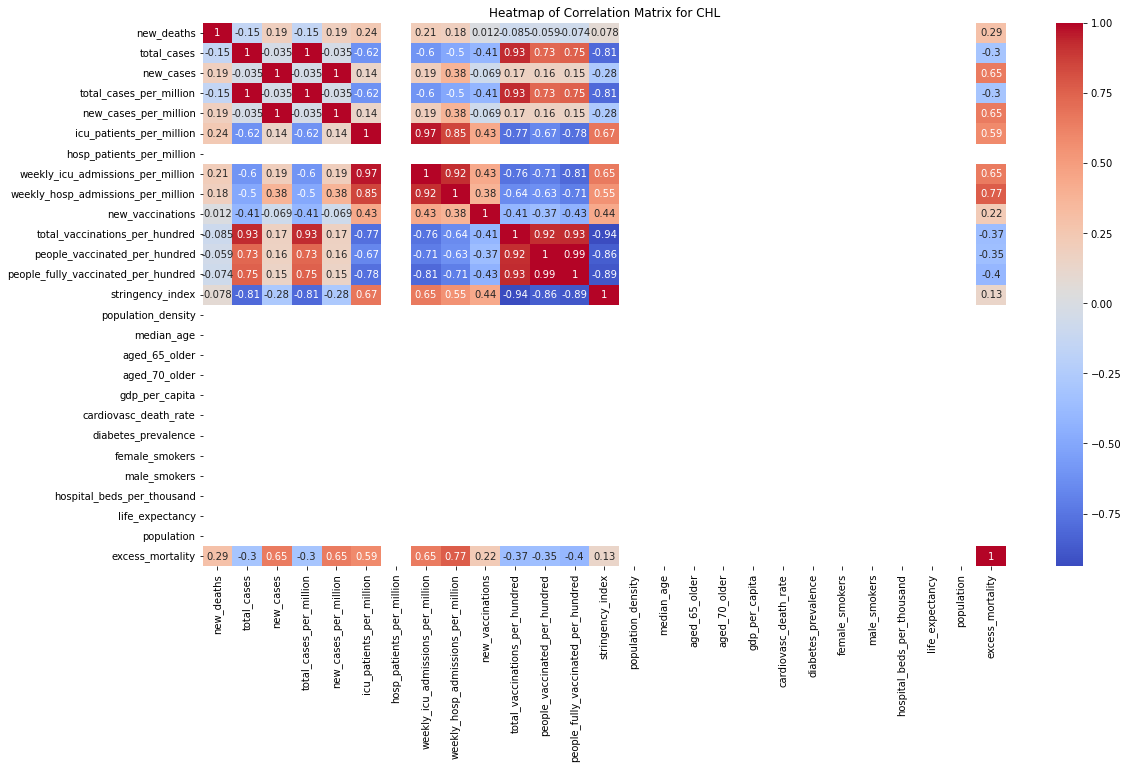

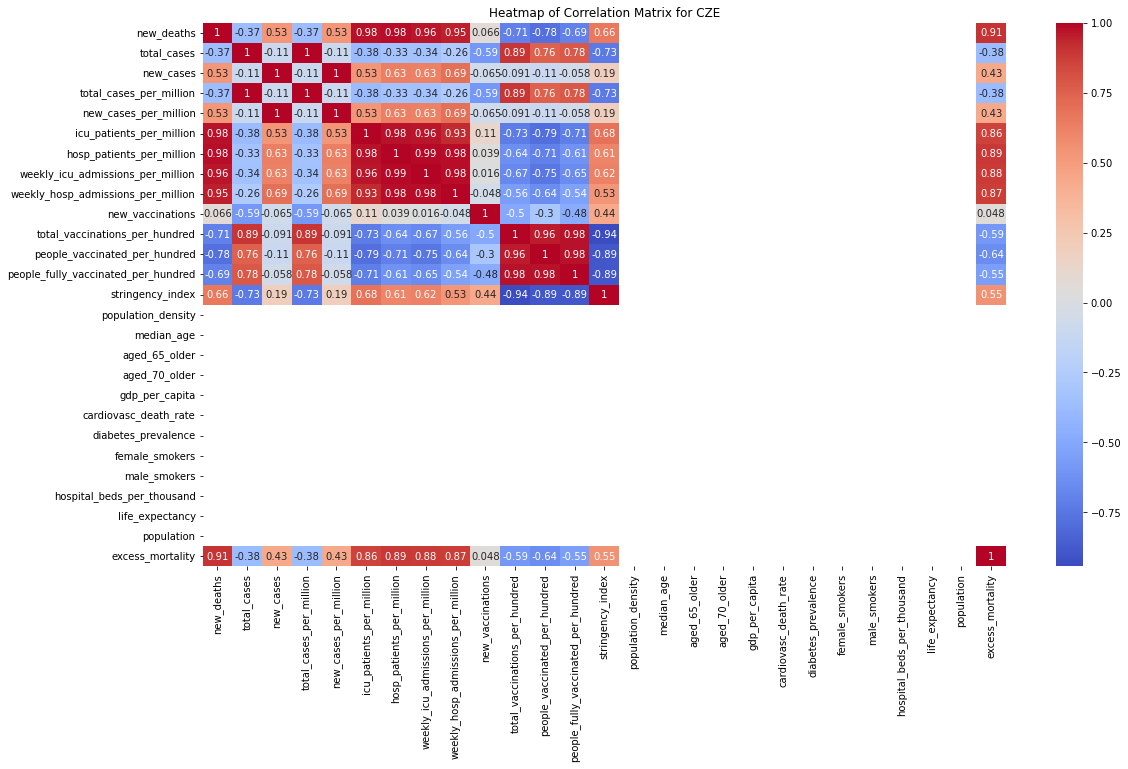

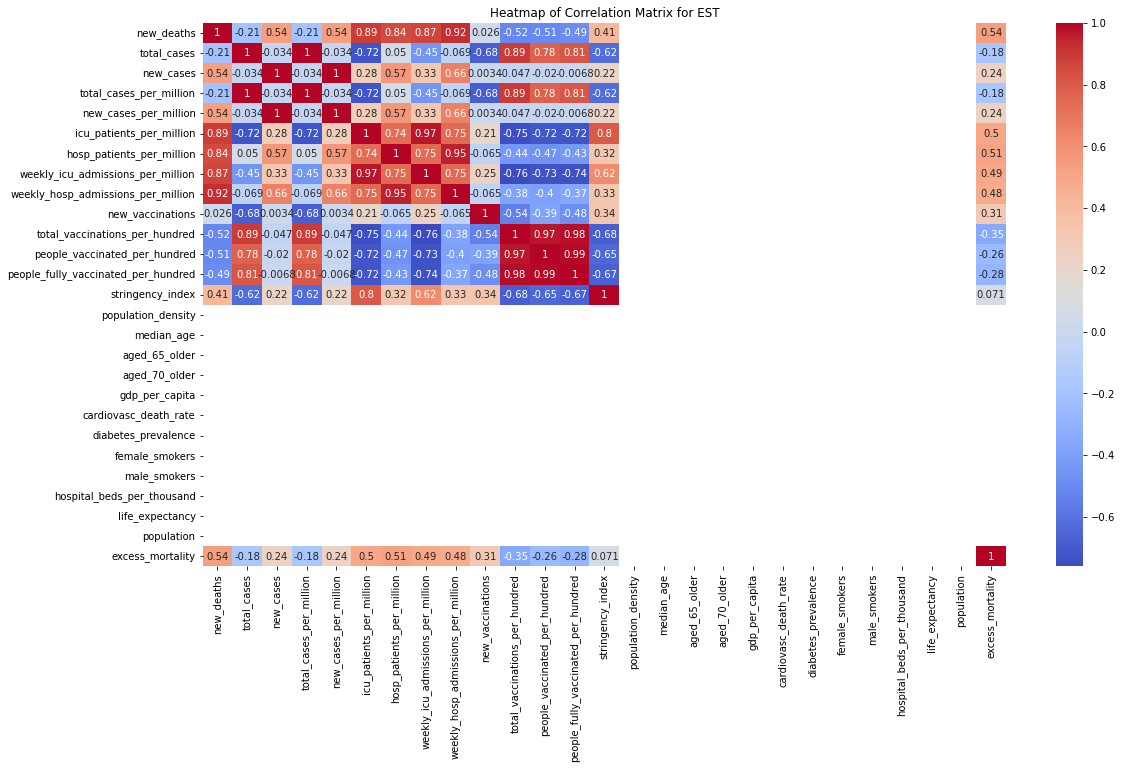

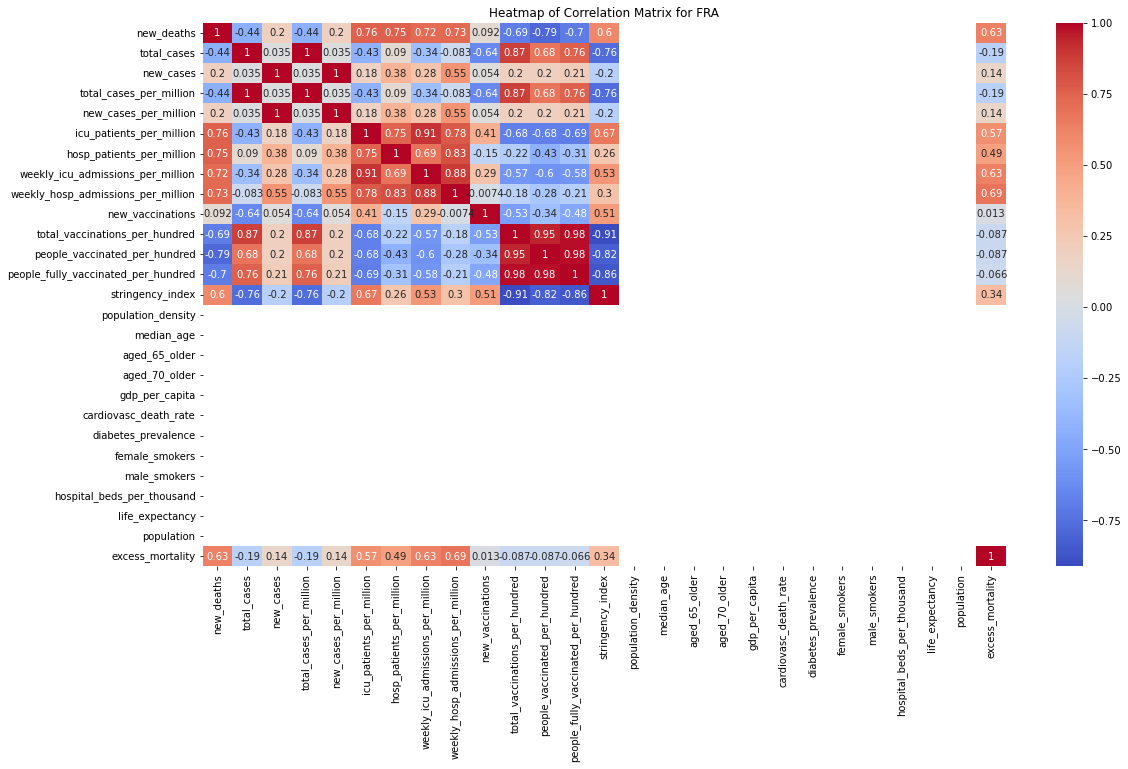

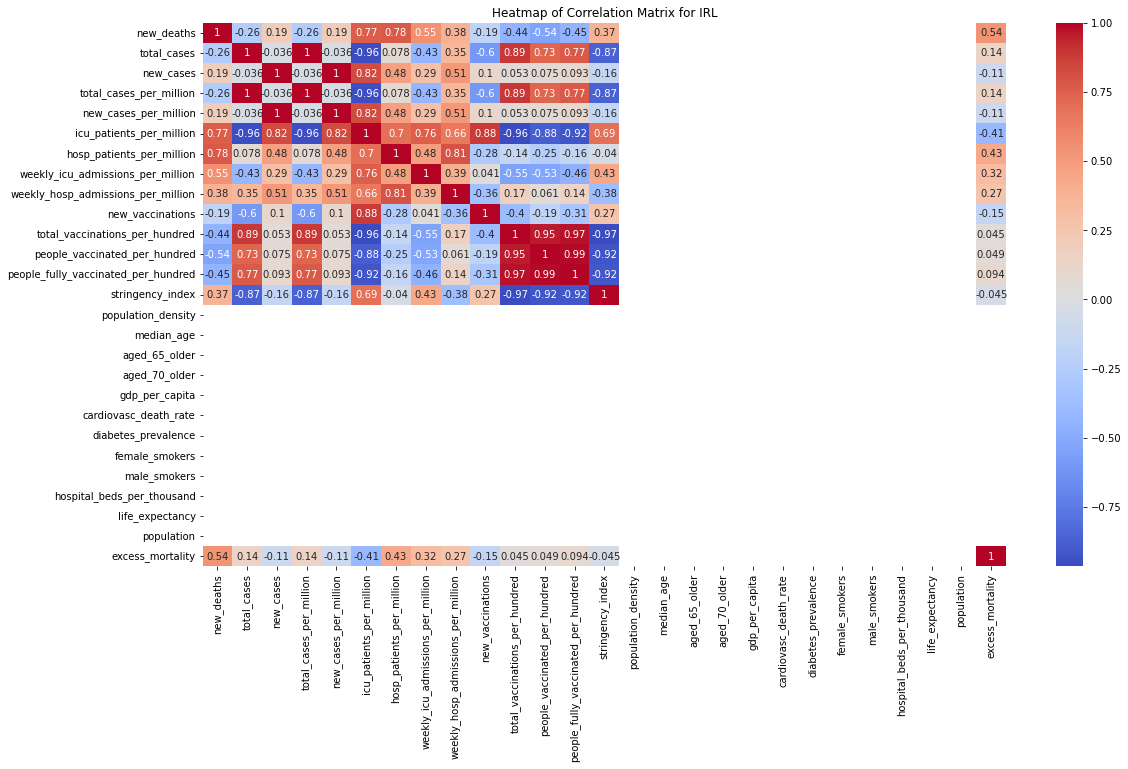

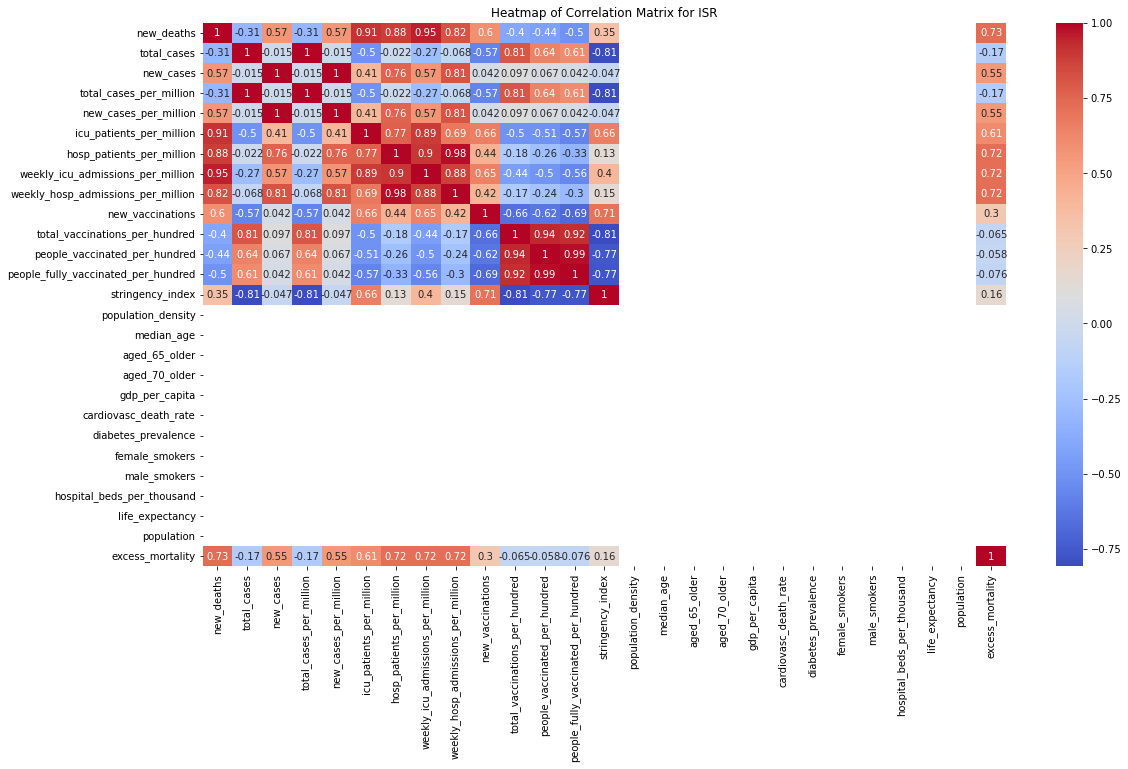

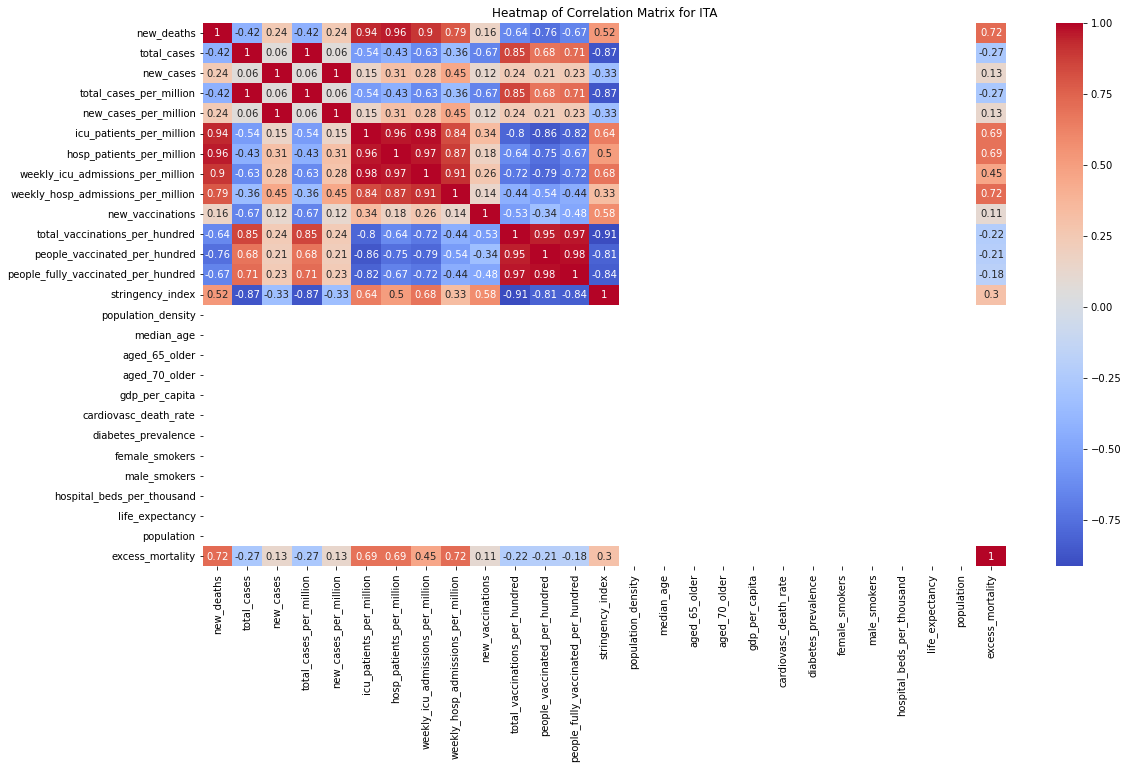

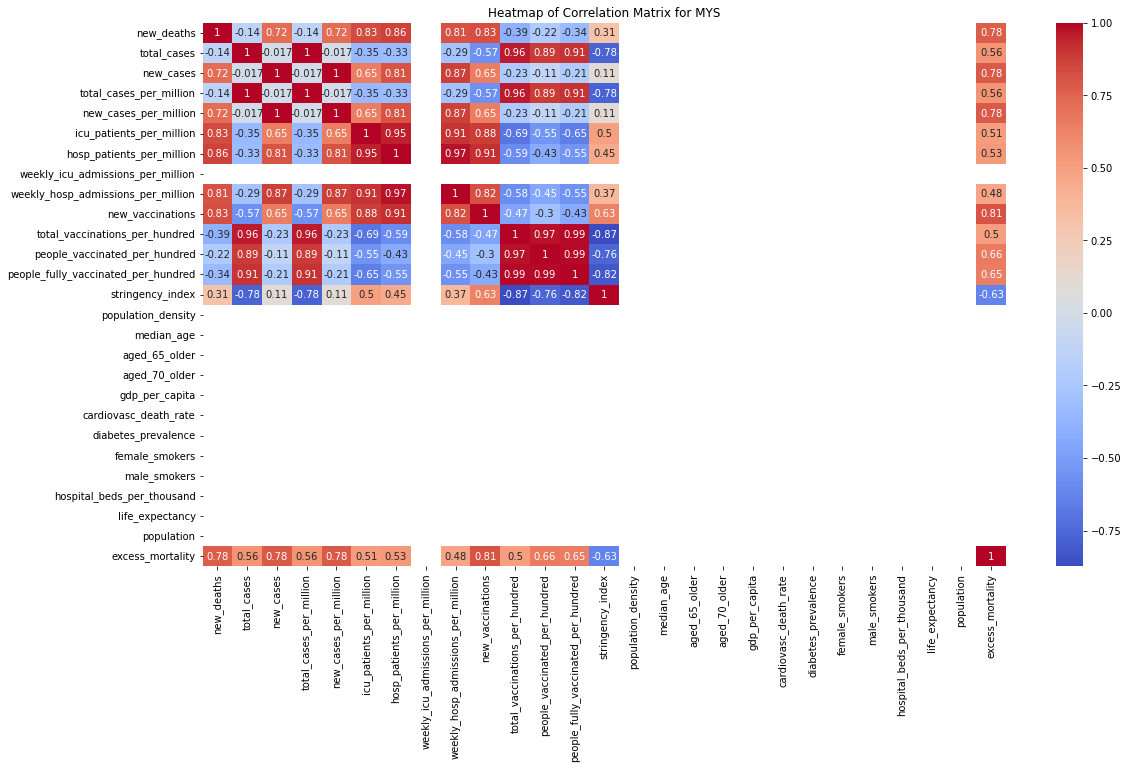

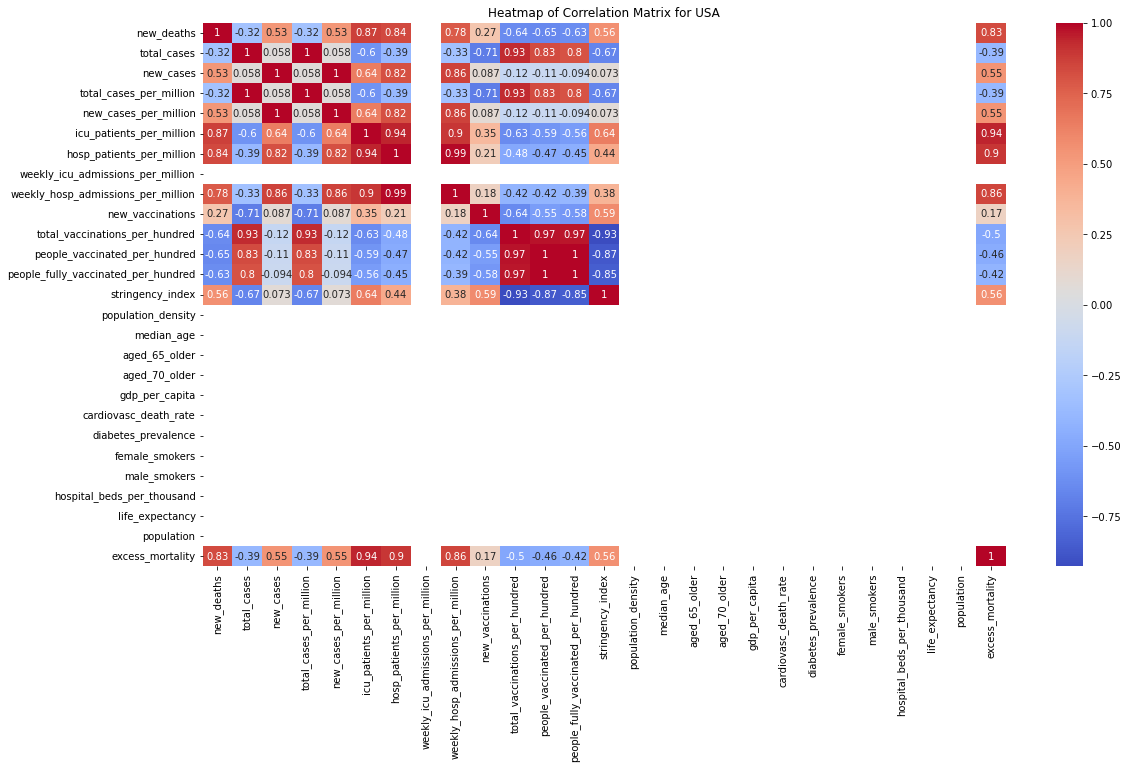

In [29]:
countries = df['iso_code'].unique()

predictors = [
    "total_cases", "new_cases", "total_cases_per_million", 
    "new_cases_per_million", "icu_patients_per_million", 
    "hosp_patients_per_million", "weekly_icu_admissions_per_million", 
    "weekly_hosp_admissions_per_million", "tests_units", 
    "new_vaccinations", "total_vaccinations_per_hundred", 
    "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred", 
    "stringency_index", "population_density", "median_age", 
    "aged_65_older", "aged_70_older", "gdp_per_capita", 
    "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", 
    "male_smokers", "hospital_beds_per_thousand", "life_expectancy", 
    "population", "excess_mortality"
]

for country in countries:
    df_country = df[df['iso_code'] == country]

    correlation_matrix = df_country[['new_deaths'] + predictors].corr()

    plt.figure(figsize=(18, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Heatmap of Correlation Matrix for {country}')
    plt.show()



In [30]:

predictors = [
    "total_cases", "new_cases", "total_cases_per_million", 
    "new_cases_per_million", "icu_patients_per_million", 
    "hosp_patients_per_million", "weekly_icu_admissions_per_million", 
    "weekly_hosp_admissions_per_million", "tests_units", 
    "new_vaccinations", "total_vaccinations_per_hundred", 
    "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred", 
    "stringency_index", "population_density", "median_age", 
    "aged_65_older", "aged_70_older", "gdp_per_capita", 
    "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", 
    "male_smokers", "hospital_beds_per_thousand", "life_expectancy", 
    "population", "excess_mortality"
]

country_correlations = {}

for country in df['iso_code'].unique():
    country_df = df[df['iso_code'] == country]
    correlation_matrix = country_df[['new_deaths'] + predictors].corr()
    new_deaths_correlations = correlation_matrix['new_deaths'].drop('new_deaths')
    country_correlations[country] = new_deaths_correlations

correlation_df = pd.DataFrame(country_correlations).T
correlation_df


,total_cases,new_cases,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,...,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
BEL,-0.417919,0.135305,-0.417919,0.135305,0.833533,0.798361,NaN,0.687131,-0.027823,-0.564159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809810
CHL,-0.145837,0.188657,-0.145837,0.188657,0.240537,NaN,0.208060,0.184385,0.012098,-0.084889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292436
CZE,-0.369679,0.528502,-0.369679,0.528502,0.976595,0.980247,0.964282,0.946896,0.065818,-0.705356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.907690
EST,-0.207891,0.537973,-0.207891,0.537973,0.889131,0.844533,0.867506,0.917510,0.026060,-0.516581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536427
FRA,-0.440520,0.195574,-0.440520,0.195574,0.756689,0.754062,0.717206,0.726607,0.091743,-0.689186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627879
IRL,-0.260743,0.186837,-0.260743,0.186837,0.766301,0.776083,0.548966,0.382006,-0.189268,-0.443830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537877
ISR,-0.308308,0.565512,-0.308308,0.565512,0.911311,0.881613,0.952836,0.822317,0.597306,-0.398568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.727000
ITA,-0.424385,0.244128,-0.424385,0.244128,0.936806,0.960329,0.901152,0.786597,0.163090,-0.639684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.719464
MYS,-0.139106,0.717361,-0.139106,0.717362,0.834814,0.864866,NaN,0.813280,0.830021,-0.389600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778646
USA,-0.321011,0.529603,-0.321011,0.529603,0.866011,0.840362,NaN,0.780994,0.267050,-0.640874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.829746


In [31]:
correlation_df_cleaned = correlation_df.dropna(axis=1, how='any')
correlation_df_cleaned

,total_cases,new_cases,total_cases_per_million,new_cases_per_million,icu_patients_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,excess_mortality
BEL,-0.417919,0.135305,-0.417919,0.135305,0.833533,0.687131,-0.027823,-0.564159,-0.612742,-0.542001,0.518348,0.809810
CHL,-0.145837,0.188657,-0.145837,0.188657,0.240537,0.184385,0.012098,-0.084889,-0.058564,-0.073874,0.078448,0.292436
CZE,-0.369679,0.528502,-0.369679,0.528502,0.976595,0.946896,0.065818,-0.705356,-0.781882,-0.693545,0.662993,0.907690
EST,-0.207891,0.537973,-0.207891,0.537973,0.889131,0.917510,0.026060,-0.516581,-0.506395,-0.490385,0.410705,0.536427
FRA,-0.440520,0.195574,-0.440520,0.195574,0.756689,0.726607,0.091743,-0.689186,-0.792899,-0.701431,0.599161,0.627879
IRL,-0.260743,0.186837,-0.260743,0.186837,0.766301,0.382006,-0.189268,-0.443830,-0.540263,-0.450582,0.374933,0.537877
ISR,-0.308308,0.565512,-0.308308,0.565512,0.911311,0.822317,0.597306,-0.398568,-0.437693,-0.502554,0.347213,0.727000
ITA,-0.424385,0.244128,-0.424385,0.244128,0.936806,0.786597,0.163090,-0.639684,-0.755434,-0.665433,0.523942,0.719464
MYS,-0.139106,0.717361,-0.139106,0.717362,0.834814,0.813280,0.830021,-0.389600,-0.217900,-0.335600,0.306633,0.778646
USA,-0.321011,0.529603,-0.321011,0.529603,0.866011,0.780994,0.267050,-0.640874,-0.649220,-0.630310,0.563197,0.829746


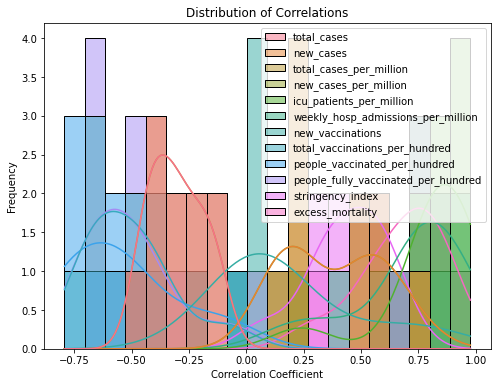


Cluster Statistics:


/var/folders/wd/1wgl396j6ddcxnk20n91fc840000gn/T/ipykernel_67996/2993567414.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df_cleaned['Cluster'] = cluster_labels


,total_cases,new_cases,total_cases_per_million,new_cases_per_million,icu_patients_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,excess_mortality
Cluster,,,,,,,,,,,,
0,-0.260743,0.186837,-0.260743,0.186837,0.766301,0.382006,-0.189268,-0.443830,-0.540263,-0.450582,0.374933,0.537877
1,-0.223707,0.641437,-0.223707,0.641437,0.873063,0.817798,0.713664,-0.394084,-0.327796,-0.419077,0.326923,0.752823
2,-0.299527,0.532026,-0.299527,0.532026,0.910579,0.881800,0.119643,-0.620937,-0.645832,-0.604747,0.545631,0.757954
3,-0.145837,0.188657,-0.145837,0.188657,0.240537,0.184385,0.012098,-0.084889,-0.058564,-0.073874,0.078448,0.292436
4,-0.427608,0.191669,-0.427608,0.191669,0.842343,0.733445,0.075670,-0.631010,-0.720358,-0.636288,0.547151,0.719051


In [32]:
correlation_stats = correlation_df_cleaned.describe()

plt.figure(figsize=(8, 6))
sns.histplot(correlation_df_cleaned, bins=20, kde=True)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Correlations')
plt.show()

from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(correlation_df_cleaned)

correlation_df_cleaned['Cluster'] = cluster_labels

cluster_stats = correlation_df_cleaned.groupby('Cluster').mean()
print("\nCluster Statistics:")
cluster_stats


total_cases and total_cases_per_million have negative mean values in all clusters, possibly indicating that as the total cases increase, new deaths could decrease.

new_cases and new_cases_per_million have positive correlations in all clusters, which suggests that as new cases increase, there's a related increase in new deaths.

icu_patients_per_million and weekly_hosp_admissions_per_million tend to have higher positive correlations in clusters 2 and 3, hinting that these clusters may represent more severe outbreak periods or regions with higher stress on the healthcare system.

new_vaccinations has a notably high positive correlation in cluster 2, which might be indicative of a strong vaccination response during certain periods or in specific regions.

excess_mortality shows positive mean correlations across all clusters but varies in magnitude, suggesting different levels of mortality impact across the clusters.

This can help in understanding what predictors would work best for each country, and for understanding the most common and impactful predictors amongst the countries.

In [33]:
correlation_df_cleaned 

,total_cases,new_cases,total_cases_per_million,new_cases_per_million,icu_patients_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,excess_mortality,Cluster
BEL,-0.417919,0.135305,-0.417919,0.135305,0.833533,0.687131,-0.027823,-0.564159,-0.612742,-0.542001,0.518348,0.809810,4
CHL,-0.145837,0.188657,-0.145837,0.188657,0.240537,0.184385,0.012098,-0.084889,-0.058564,-0.073874,0.078448,0.292436,3
CZE,-0.369679,0.528502,-0.369679,0.528502,0.976595,0.946896,0.065818,-0.705356,-0.781882,-0.693545,0.662993,0.907690,2
EST,-0.207891,0.537973,-0.207891,0.537973,0.889131,0.917510,0.026060,-0.516581,-0.506395,-0.490385,0.410705,0.536427,2
FRA,-0.440520,0.195574,-0.440520,0.195574,0.756689,0.726607,0.091743,-0.689186,-0.792899,-0.701431,0.599161,0.627879,4
IRL,-0.260743,0.186837,-0.260743,0.186837,0.766301,0.382006,-0.189268,-0.443830,-0.540263,-0.450582,0.374933,0.537877,0
ISR,-0.308308,0.565512,-0.308308,0.565512,0.911311,0.822317,0.597306,-0.398568,-0.437693,-0.502554,0.347213,0.727000,1
ITA,-0.424385,0.244128,-0.424385,0.244128,0.936806,0.786597,0.163090,-0.639684,-0.755434,-0.665433,0.523942,0.719464,4
MYS,-0.139106,0.717361,-0.139106,0.717362,0.834814,0.813280,0.830021,-0.389600,-0.217900,-0.335600,0.306633,0.778646,1
USA,-0.321011,0.529603,-0.321011,0.529603,0.866011,0.780994,0.267050,-0.640874,-0.649220,-0.630310,0.563197,0.829746,2


PCA Loadings:
                                          PC1       PC2       PC3
total_cases                          0.037234 -0.039189  0.376906
new_cases                            0.102385  0.104998  0.332141
new_deaths                           0.108539  0.179894  0.352610
total_cases_per_million              0.015589 -0.248141  0.027223
new_cases_per_million                0.117677  0.061940  0.040152
icu_patients_per_million             0.206448  0.286053 -0.050495
hosp_patients_per_million            0.251753  0.203423 -0.046611
weekly_icu_admissions_per_million    0.146309  0.273366 -0.110879
weekly_hosp_admissions_per_million   0.170875  0.267958 -0.012998
new_vaccinations                     0.058106  0.139200  0.259251
total_vaccinations_per_hundred      -0.161198 -0.272184  0.125796
people_vaccinated_per_hundred       -0.163611 -0.264824  0.155367
people_fully_vaccinated_per_hundred -0.167763 -0.265291  0.122886
stringency_index                     0.091313  0.250360 -0.050

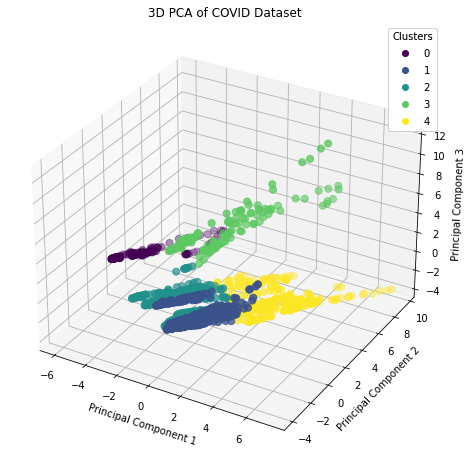

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

numerical_df = df.select_dtypes(include=['int64', 'float64'])
numerical_df['new_deaths'].fillna(method='bfill', inplace=True)  
numerical_df.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_df_imputed = imputer.fit_transform(numerical_df)
numerical_df = pd.DataFrame(numerical_df_imputed, columns=numerical_df.columns)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_df)


pca = PCA(n_components=3)  
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3'], index=numerical_df.columns)
print("PCA Loadings:")
print(loadings_df)

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    corr = np.corrcoef(numerical_df['new_deaths'], principal_components[:, i])[0, 1]
    print(f"Correlation of 'new_deaths' with {pc}: {corr:.2f}")

kmeans = KMeans(n_clusters=5) 
principal_df['Cluster'] = kmeans.fit_predict(principal_components)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], principal_df['PC3'],
                     c=principal_df['Cluster'], s=50)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of COVID Dataset')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


The correlation values suggest that new_deaths is most strongly correlated with PC3, then PC2, and has a weaker correlation with PC1. Since these are all positive correlations, we can infer that as the values for PC3 increase, the number of new_deaths tends to increase as well. It is also important to look at other variables that have high loadings on PC3, as these may be associated with new_deaths. For example, variables related to vaccinations and GDP have high loadings on PC1, suggesting that this component may represent the severity of the pandemic in terms of the economic impact.

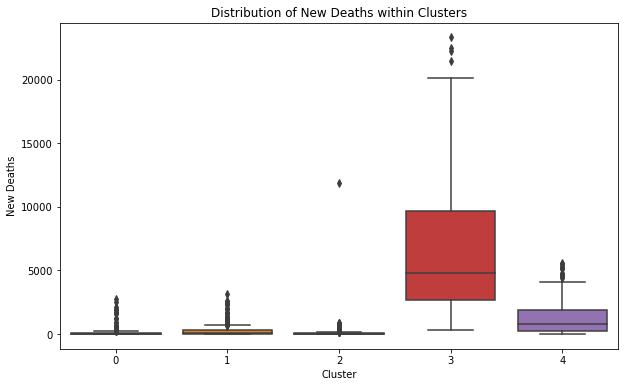

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,207.0,180.159420,430.971356,0.0,3.0,26.0,85.0,2732.0
1,681.0,237.328928,384.050840,0.0,21.0,72.0,292.0,3157.0
2,703.0,84.578947,459.297264,0.0,6.0,21.0,79.5,11858.0
3,165.0,6830.806061,5438.687551,305.0,2642.0,4776.0,9678.0,23312.0
4,251.0,1235.003984,1313.348427,3.0,272.5,763.0,1902.5,5602.0


In [35]:
df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))

sns.boxplot(x='Cluster', y='new_deaths', data=df)

plt.title('Distribution of New Deaths within Clusters')
plt.xlabel('Cluster')
plt.ylabel('New Deaths')
plt.show()

cluster_summary = df.groupby('Cluster')['new_deaths'].describe()
cluster_summary


Cluster 0 has the highest count of data points, but its mean and maximum new_deaths are lower than some other clusters.

Cluster 1 has the lowest mean and a smaller count, indicating that it generally represents areas or times with fewer new deaths.

Cluster 2 shows a higher mean and standard deviation, which corresponds to the wider distribution.

Cluster 3 has the highest mean by a significant margin, and the maximum value in this cluster is the largest in the dataset, indicating this cluster includes the most severe instances in terms of new deaths.

Cluster 4 has a low mean, similar to Clusters 0 and 1, but includes a very high maximum value due to outliers.

In [36]:
# temporal patterns
df['date'] = pd.to_datetime(df['date'])
cluster_temporal_patterns = df.groupby('Cluster')['date'].agg(['min', 'max'])

# geographical patterns
cluster_geographical_patterns = df.groupby(['Cluster', 'location']).size().reset_index(name='count')

# healthcare capacity
cluster_healthcare_capacity = df.groupby('Cluster')['icu_patients_per_million', 'hosp_patients_per_million'].mean()

# public health interventions
cluster_public_health_interventions = df.groupby('Cluster')['stringency_index'].mean()

# vaccination rates
cluster_vaccination_rates = df.groupby('Cluster')['people_fully_vaccinated_per_hundred'].mean()

# demographic and socioeconomic factors
cluster_demographics = df.groupby('Cluster')['median_age', 'population_density', 'gdp_per_capita'].mean()


/var/folders/wd/1wgl396j6ddcxnk20n91fc840000gn/T/ipykernel_67996/378924622.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_healthcare_capacity = df.groupby('Cluster')['icu_patients_per_million', 'hosp_patients_per_million'].mean()
/var/folders/wd/1wgl396j6ddcxnk20n91fc840000gn/T/ipykernel_67996/378924622.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_demographics = df.groupby('Cluster')['median_age', 'population_density', 'gdp_per_capita'].mean()


Takeaways from Cluster Analysis: 

- Cluster 0:
    - Spans the entire date range, suggesting that this cluster may represent general trends over the course of the pandemic. 
    - Has lower ICU and hospital patients per million, which might indicate lower pressure on healthcare resources.
    - Has lower stringency index values, which could correlate with fewer restrictions or public health interventions.
    - Has the highest rate of fully vaccinated people, which might be associated with lower mortality if vaccinations are effective.
    - Has higher median age and GDP per capita, which might suggest wealthier and older population.

- Cluster 1:
    - Spans the entire date range, suggesting that this cluster may represent general trends over the course of the pandemic. 
    - Has the lowest healthcare capacity usage, which could correlate with lower rates of new deaths.
    - Has a slightly higher stringency index than Clusters 0 and 4, potentially indicating more stringent public health measures.
    - Has moderate vaccination rates.
    - Has the lowest median age and population density, which could indicate younger populations that might be less affected by COVID-19 or different testing/reporting rates.

- Cluster 2:
    - Has a narrower date range, ending in March 2022, which might represent a specific wave or period within the pandemic.
    - Shows significantly higher healthcare capacity usage, suggesting severe outbreaks.
    - Has the highest stringency index, which may reflect stricter lockdown measures or responses to severe outbreaks.
    - Has the lowest vaccination rates, which may have contributed to higher hospitalization and ICU rates.
    - Has higher median age and GDP per capita, which might suggest wealthier and older population.

- Cluster 3: 
    - Ends in May 2023, which could indicate a period with distinct characteristics separate from the general trends.
    - Exclusively made up of USA data.
    - Has moderate ICU usage but lower hospitalization rates than Cluster 2, which could be due to different healthcare practices, population health, or availability of healthcare resources in the United States.
    - Has a stringency index similar to Cluster 1, which might suggest similar public health policies or responses.
    - Has a lower vaccination rate than Cluster 0, which may be a factor in its higher rate of new deaths.as a high GDP per capita, consistent with the U.S., but a lower median age, which could suggest a wider spread among a younger population.

- Cluster 4: 
    - Spans the entire date range, suggesting that this cluster may represent general trends over the course of the pandemic. 
    - Has lower ICU and hospital patients per million, which might indicate lower pressure on healthcare resources.
    - Has lower stringency index values, which could correlate with fewer restrictions or public health interventions.
    - Has moderate vaccination rates.
    - Has a median range for demographic and socioeconomic factors, indicating a diverse representation.

# Temporal Visualization 

In [37]:
data

,iso_code,continent,location,date,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,...,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality,Cluster
24345,BEL,Europe,Belgium,2020-02-09,1.0,1.0,0.0,0.086,0.086,NaN,...,42658.576,114.898,4.29,25.1,31.4,5.64,81.63,11655923.0,-12.66,1
24346,BEL,Europe,Belgium,2020-02-16,1.0,0.0,0.0,0.086,0.000,NaN,...,42658.576,114.898,4.29,25.1,31.4,5.64,81.63,11655923.0,-8.40,1
24347,BEL,Europe,Belgium,2020-02-23,1.0,0.0,0.0,0.086,0.000,NaN,...,42658.576,114.898,4.29,25.1,31.4,5.64,81.63,11655923.0,-7.32,1
24348,BEL,Europe,Belgium,2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,...,42658.576,114.898,4.29,25.1,31.4,5.64,81.63,11655923.0,-11.45,1
24355,BEL,Europe,Belgium,2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,...,42658.576,114.898,4.29,25.1,31.4,5.64,81.63,11655923.0,-9.63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261106,USA,North America,United States,2023-04-16,103081453.0,104057.0,1290.0,304713.402,307.597,4.662,...,54225.446,151.089,10.79,19.1,24.6,2.77,78.86,338289856.0,0.67,3
261113,USA,North America,United States,2023-04-23,103179920.0,98467.0,1198.0,305004.475,291.073,3.825,...,54225.446,151.089,10.79,19.1,24.6,2.77,78.86,338289856.0,0.54,3
261120,USA,North America,United States,2023-04-30,103266404.0,86484.0,1046.0,305260.126,255.651,3.589,...,54225.446,151.089,10.79,19.1,24.6,2.77,78.86,338289856.0,0.50,3
261127,USA,North America,United States,2023-05-07,103343569.0,77165.0,1146.0,305488.229,228.103,3.258,...,54225.446,151.089,10.79,19.1,24.6,2.77,78.86,338289856.0,0.88,3


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates

time = data[['new_deaths','location', 'date']]
type(time)

pandas.core.frame.DataFrame

/var/folders/wd/1wgl396j6ddcxnk20n91fc840000gn/T/ipykernel_67996/3946026173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['date'] = pd.to_datetime(time['date'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'pandas.core.frame.DataFrame'>


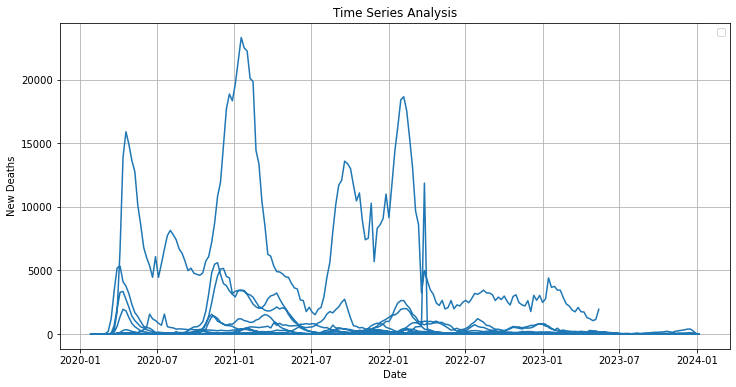

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming 'date' column is not in datetime format, convert it
time['date'] = pd.to_datetime(time['date'])

# Convert 'date' and 'new_deaths' columns to NumPy arrays
date_array = time['date'].to_numpy()
new_deaths_array = time['new_deaths'].to_numpy()

# Confirm the type of the 'time' DataFrame
print(type(time))

# Perform time series analysis using NumPy arrays
plt.figure(figsize=(12, 6))
plt.plot(date_array, new_deaths_array)  # Assuming there's only one location for simplicity
plt.title(f'Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/wd/1wgl396j6ddcxnk20n91fc840000gn/T/ipykernel_67996/3542778006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['date'] = pd.to_datetime(time['date'])


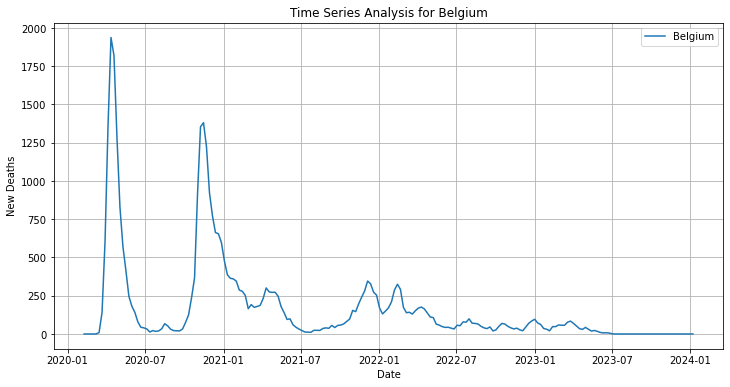

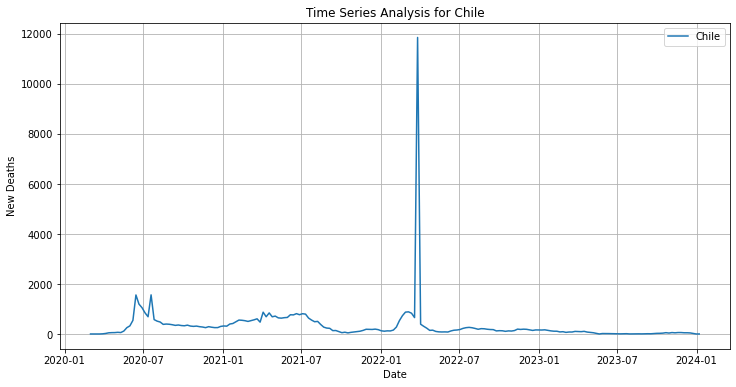

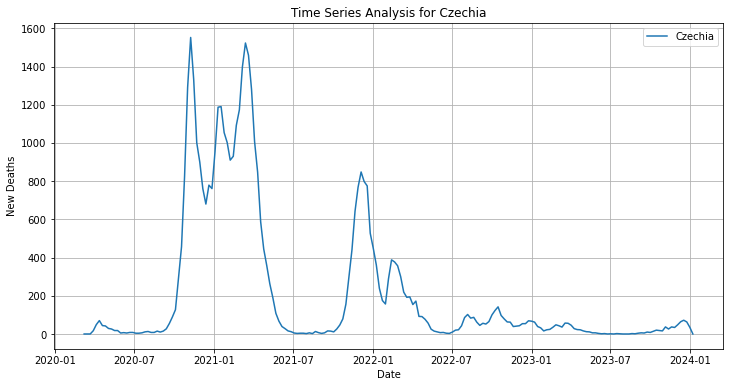

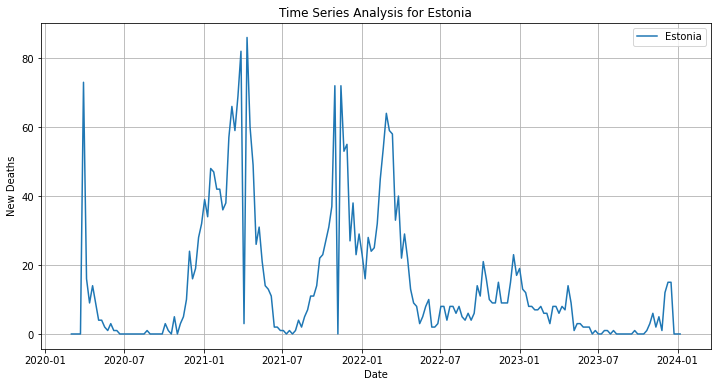

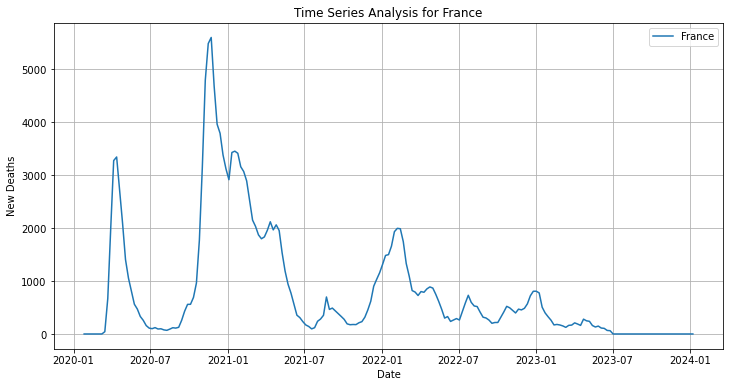

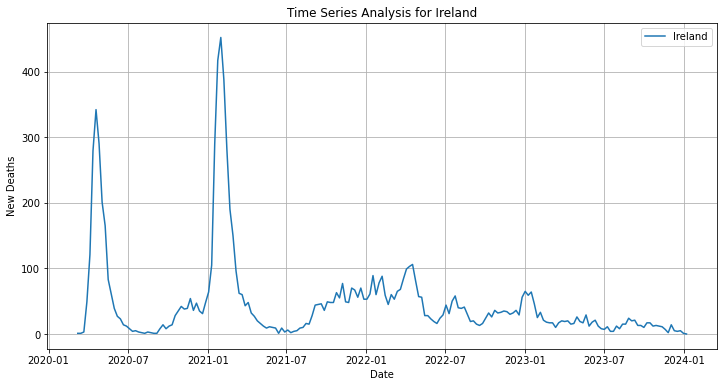

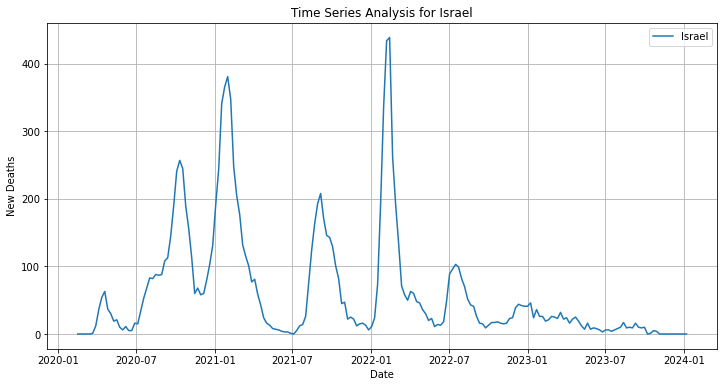

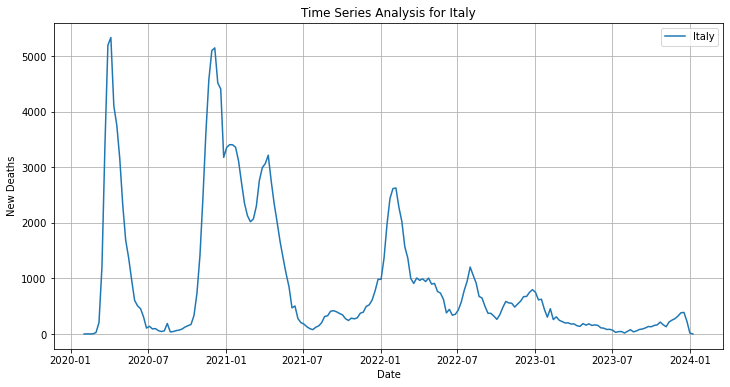

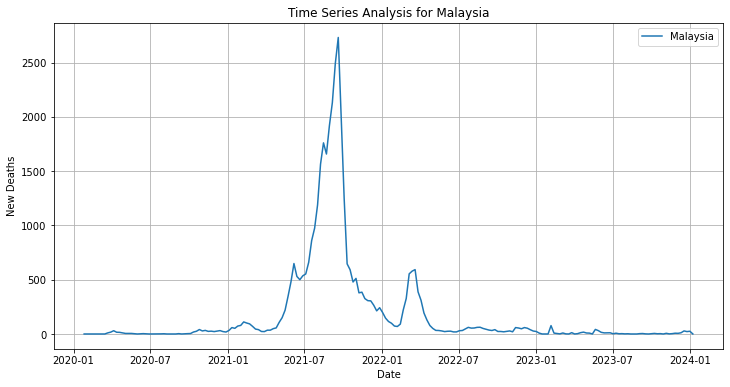

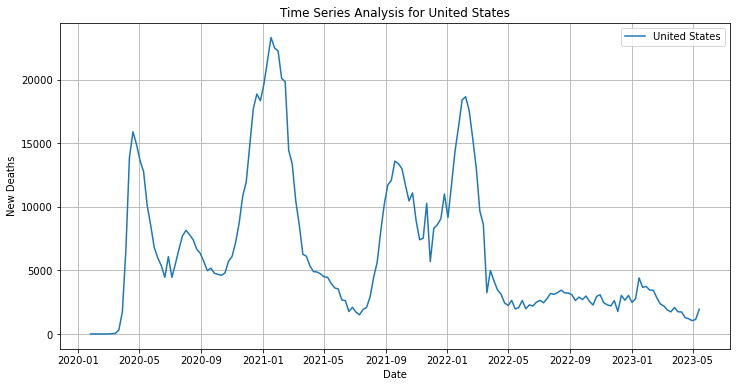

In [40]:
# Assuming 'date' column is not in datetime format, convert it
time['date'] = pd.to_datetime(time['date'])

# Get a sample of 10 unique countries for simplicity
countries = time['location'].unique()[:10]


for country in countries:
    # Subset data for the current country
    country_data = time[time['location'] == country]

    # Convert 'date' and 'new_deaths' columns to NumPy arrays
    date_array = country_data['date'].to_numpy()
    new_deaths_array = country_data['new_deaths'].to_numpy()

    # Basic time series analysis
    plt.figure(figsize=(12, 6))
    plt.plot(date_array, new_deaths_array, label=country)
    plt.title(f'Time Series Analysis for {country}')
    plt.xlabel('Date')
    plt.ylabel('New Deaths')
    plt.legend()
    plt.grid(True)
    plt.show()

# Feature Engineering

In [47]:
! pip install --upgrade holidays

     |████████████████████████████████| 913 kB 1.6 MB/s eta 0:00:01


In [48]:
import holidays
import datetime

In [77]:
## Shifting by 1, 2, 4 weeks
df['new_deaths_1_week_lag'] = df['new_deaths'].shift(1)
df['new_deaths_2_week_lag'] = df['new_deaths'].shift(2)
df['new_deaths_4_week_lag'] = df['new_deaths'].shift(4)

df['new_deaths_1_week_mean'] = df['new_deaths'].rolling(window=1).mean()
df['new_deaths_2_week_mean'] = df['new_deaths'].rolling(window=2).mean()
df['new_deaths_4_week_mean'] = df['new_deaths'].rolling(window=4).mean()

df['new_deaths_1_week_std'] = df['new_deaths'].rolling(window=1).std()
df['new_deaths_2_week_std'] = df['new_deaths'].rolling(window=2).std()
df['new_deaths_4_week_std'] = df['new_deaths'].rolling(window=4).std()

df['new_deaths_1_week_max'] = df['new_deaths'].rolling(window=1).max()
df['new_deaths_2_week_max'] = df['new_deaths'].rolling(window=2).max()
df['new_deaths_4_week_max'] = df['new_deaths'].rolling(window=4).max()
df['new_deaths_1_week_min'] = df['new_deaths'].rolling(window=1).min()
df['new_deaths_2_week_min'] = df['new_deaths'].rolling(window=2).min()
df['new_deaths_4_week_min'] = df['new_deaths'].rolling(window=4).min()

## Other time series features
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)
df['season'] = df['date'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or 
                                      x.month == 2 else 'Spring' if  x.month == 3 or 
                                      x.month == 4 or x.month == 5 else 'Summer' if  
                                      x.month == 6 or x.month == 7 or 
                                      x.month == 8 else 'Autumn' if  
                                      x.month == 9 or x.month == 10 or x.month == 11 else '')
df['holidays'] = df['date'].apply( lambda x: 'Holiday' if x in holidays.US() 
                                      else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)

## Comparing each value with its previous value
df['comparison_with_previous'] = df['new_deaths'] - df['new_deaths'].shift(1)

## Growth rate of Cases & Deaths
df['growth_rate_cases'] = df['total_cases'].pct_change().multiply(100)
df['growth_rate_deaths'] = df['new_deaths'].pct_change().multiply(100)

## Healthcare Capacity (Calculate ICU utilization ratio per thousand beds) ;;;make sure to check for zeros and fill in NaNs
df['icu_utilization_ratio'] = df['icu_patients_per_million'] / (df['hospital_beds_per_thousand'] * 10)

## Healthcare Strain 
df['healthcare_strain_index'] = (df['icu_patients_per_million'] + df['hosp_patients_per_million']) / df['hospital_beds_per_thousand']

## Elderly cases ratio
df['elderly_to_cases_ratio'] = df['aged_65_older'] / df['total_cases_per_million']

## Cumulative (count of the number of times a location had new cases exceed a certain threshold)
df['cumulative_cases_threshold'] = (df['new_cases'] > threshold).cumsum()

## Interaction term between gdp and stringency (economic impact of policy)
df['gdp_stringency_interaction'] = df['gdp_per_capita'] * df['stringency_index']

df

,iso_code,continent,location,date,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,...,comparison_with_previous,growth_rate_cases,growth_rate_deaths,icu_utilization_ratio,healthcare_strain_index,elderly_to_cases_ratio,cumulative_cases_threshold,gdp_stringency_interaction,month_sin,month_cos
24345,BEL,Europe,Belgium,2020-02-09,1.0,1.0,0.0,0.086,0.086,NaN,...,NaN,NaN,NaN,NaN,NaN,215.941860,1,473936.77936,0.866025,5.000000e-01
24346,BEL,Europe,Belgium,2020-02-16,1.0,0.0,0.0,0.086,0.000,NaN,...,0.0,0.000000,NaN,NaN,NaN,215.941860,1,473936.77936,0.866025,5.000000e-01
24347,BEL,Europe,Belgium,2020-02-23,1.0,0.0,0.0,0.086,0.000,NaN,...,0.0,0.000000,NaN,NaN,NaN,215.941860,1,473936.77936,0.866025,5.000000e-01
24348,BEL,Europe,Belgium,2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,...,0.0,0.000000,NaN,NaN,NaN,215.941860,1,473936.77936,1.000000,6.123234e-17
24355,BEL,Europe,Belgium,2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,...,0.0,31500.000000,NaN,0.000000,0.000000,0.684999,2,592527.62064,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261106,USA,North America,United States,2023-04-16,103081453.0,104057.0,1290.0,304713.402,307.597,4.662,...,-439.0,0.101048,-25.390399,0.168303,14.220217,0.000051,1934,NaN,0.866025,-5.000000e-01
261113,USA,North America,United States,2023-04-23,103179920.0,98467.0,1198.0,305004.475,291.073,3.825,...,-92.0,0.095523,-7.131783,0.138087,12.410108,0.000051,1935,NaN,0.866025,-5.000000e-01
261120,USA,North America,United States,2023-04-30,103266404.0,86484.0,1046.0,305260.126,255.651,3.589,...,-152.0,0.083819,-12.687813,0.129567,11.264982,0.000050,1936,NaN,0.866025,-5.000000e-01
261127,USA,North America,United States,2023-05-07,103343569.0,77165.0,1146.0,305488.229,228.103,3.258,...,100.0,0.074724,9.560229,0.117617,10.168231,0.000050,1937,NaN,0.500000,-8.660254e-01


## EDA of new features

In [78]:
features_and_target = df[['new_deaths', 'new_deaths_1_week_lag', 'new_deaths_2_week_lag', 'new_deaths_4_week_lag',
                          'new_deaths_1_week_mean', 'new_deaths_2_week_mean', 'new_deaths_4_week_mean',
                          'new_deaths_1_week_std', 'new_deaths_2_week_std', 'new_deaths_4_week_std',
                          'new_deaths_1_week_max', 'new_deaths_2_week_max', 'new_deaths_4_week_max',
                          'new_deaths_1_week_min', 'new_deaths_2_week_min', 'new_deaths_4_week_min',
                          'dayofweek','quarter','month','year', 'dayofyear','dayofmonth', 'weekofyear',
                          'season', 'holidays', 'comparison_with_previous', 'growth_rate_cases', 
                          'growth_rate_deaths', 'icu_utilization_ratio', 'healthcare_strain_index',
                          'elderly_to_cases_ratio', 'cumulative_cases_threshold', 'gdp_stringency_interaction',
                          'month_sin', 'month_cos']]

<AxesSubplot:xlabel='season', ylabel='count'>

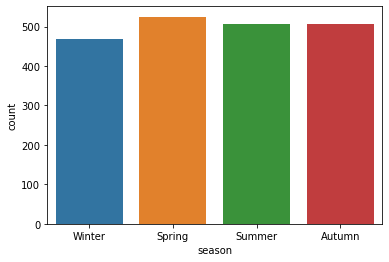

In [79]:
sns.countplot( x = 'season', data = df)

<AxesSubplot:xlabel='holidays', ylabel='count'>

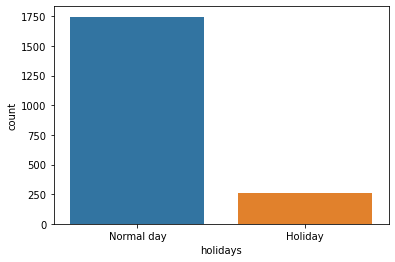

In [80]:
sns.countplot(x = 'holidays', data = df)

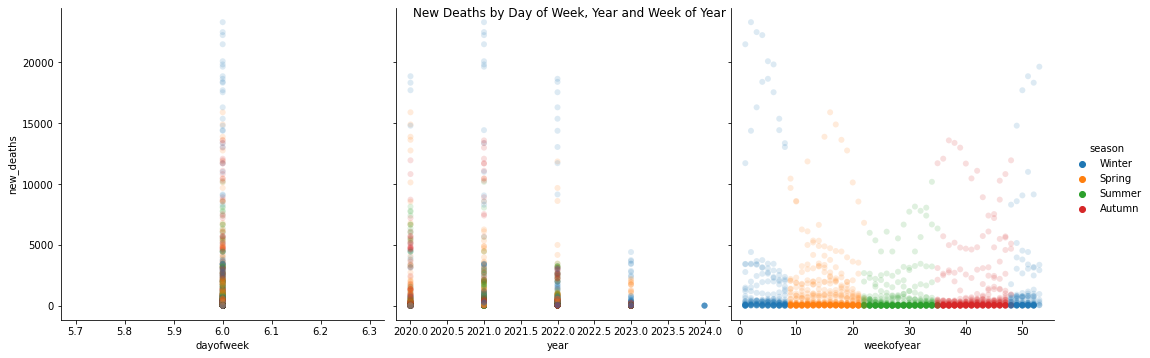

In [81]:
sns.pairplot(df,
             hue='season',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='new_deaths',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0})
plt.suptitle('New Deaths by Day of Week, Year and Week of Year')
plt.show()

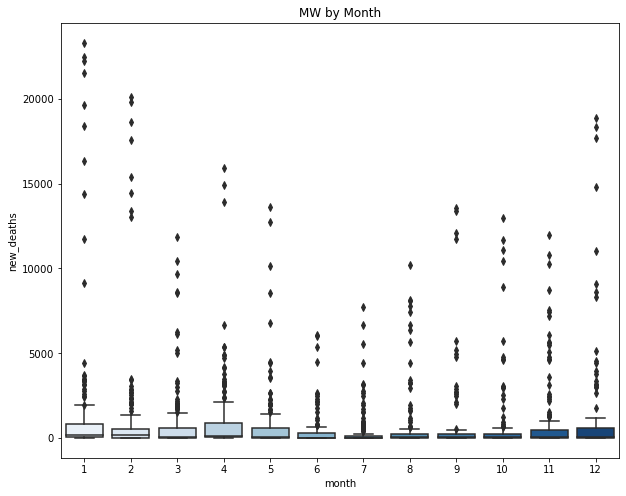

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_and_target, x='month', y='new_deaths', palette='Blues')
ax.set_title('MW by Month')
plt.show()

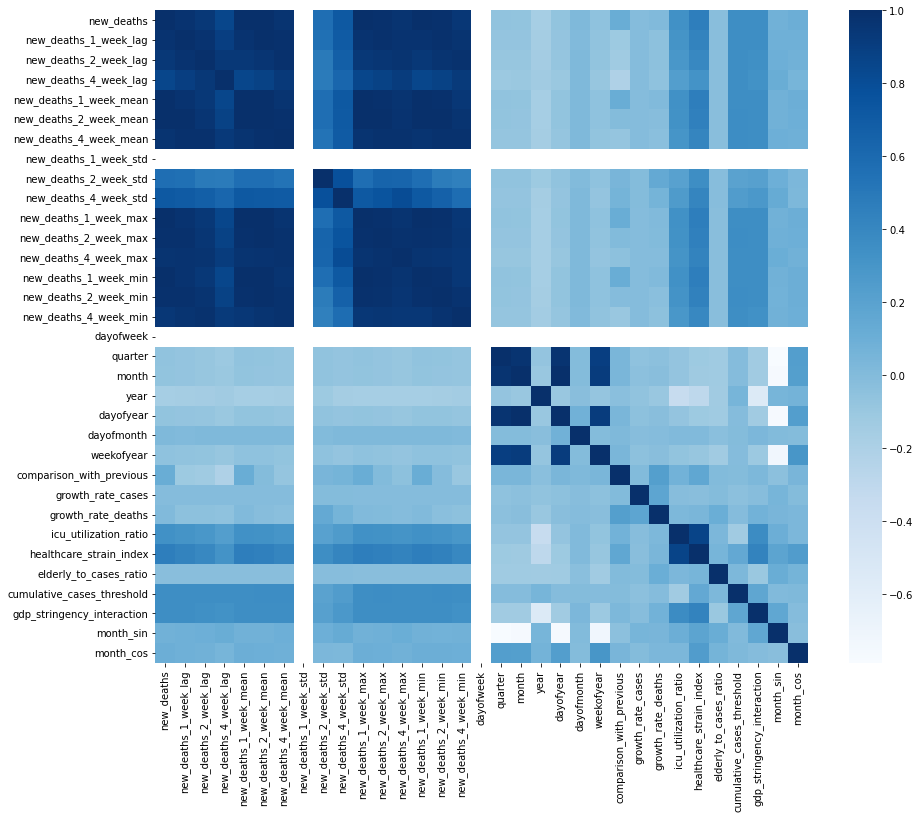

In [83]:
corrmat = features_and_target.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmat,cmap="Blues", square=True);

In [88]:
correlation_matrix = features_and_target.corr()['new_deaths']
sorted_correlations = correlation_matrix.abs().sort_values(ascending=False)
sorted_correlations

new_deaths                    1.000000
new_deaths_1_week_min         1.000000
new_deaths_1_week_max         1.000000
new_deaths_1_week_mean        1.000000
new_deaths_2_week_mean        0.993095
new_deaths_2_week_max         0.989840
new_deaths_2_week_min         0.987420
new_deaths_1_week_lag         0.972474
new_deaths_4_week_mean        0.971850
new_deaths_4_week_max         0.965151
new_deaths_4_week_min         0.949625
new_deaths_2_week_lag         0.942462
new_deaths_4_week_lag         0.850252
new_deaths_4_week_std         0.715774
new_deaths_2_week_std         0.569891
healthcare_strain_index       0.462350
cumulative_cases_threshold    0.356804
gdp_stringency_interaction    0.356585
icu_utilization_ratio         0.330798
year                          0.163250
comparison_with_previous      0.117400
month_cos                     0.102617
month_sin                     0.078351
month                         0.065718
dayofyear                     0.062856
quarter                  

In [89]:
sorted_correlations.drop(['new_deaths', 'new_deaths_1_week_min', 'new_deaths_1_week_max',
                          'new_deaths_1_week_mean']).head(10)

new_deaths_2_week_mean    0.993095
new_deaths_2_week_max     0.989840
new_deaths_2_week_min     0.987420
new_deaths_1_week_lag     0.972474
new_deaths_4_week_mean    0.971850
new_deaths_4_week_max     0.965151
new_deaths_4_week_min     0.949625
new_deaths_2_week_lag     0.942462
new_deaths_4_week_lag     0.850252
new_deaths_4_week_std     0.715774
Name: new_deaths, dtype: float64

<AxesSubplot:xlabel='new_deaths_2_week_mean', ylabel='Count'>

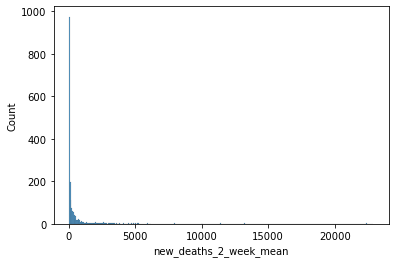

In [92]:
sns.histplot( df['new_deaths_2_week_mean'], kde=False )

<AxesSubplot:xlabel='new_deaths_2_week_mean', ylabel='new_deaths'>

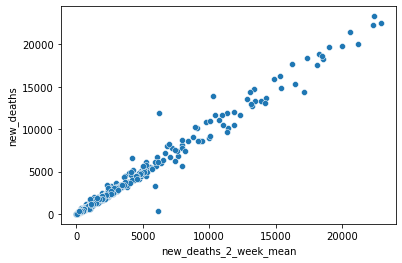

In [98]:
sns.scatterplot(data = features_and_target, x = 'new_deaths_2_week_mean', y = 'new_deaths')

<AxesSubplot:xlabel='new_deaths_2_week_max', ylabel='Count'>

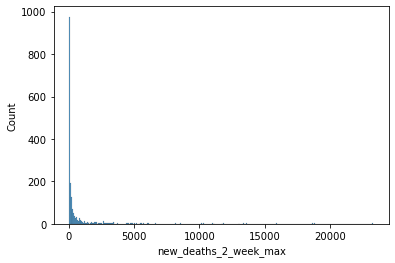

In [93]:
sns.histplot( df['new_deaths_2_week_max'], kde=False )

<AxesSubplot:xlabel='new_deaths_2_week_max', ylabel='new_deaths'>

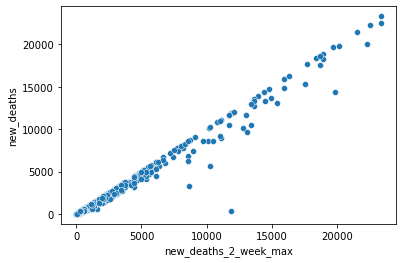

In [99]:
sns.scatterplot(data = features_and_target, x = 'new_deaths_2_week_max', y = 'new_deaths')

<AxesSubplot:xlabel='new_deaths_2_week_min', ylabel='Count'>

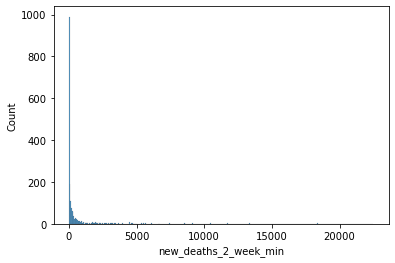

In [94]:
sns.histplot( df['new_deaths_2_week_min'], kde=False )

<AxesSubplot:xlabel='new_deaths_2_week_min', ylabel='new_deaths'>

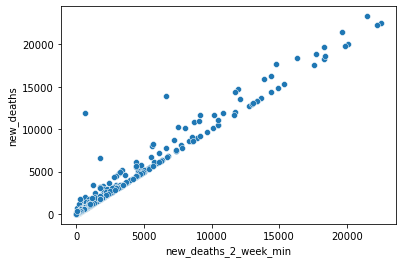

In [100]:
sns.scatterplot(data = features_and_target, x = 'new_deaths_2_week_min', y = 'new_deaths')

In [106]:
full_correlation_matrix = df.corr()['new_deaths']
full_sorted_correlations = full_correlation_matrix.abs().sort_values(ascending=False)
sorted_correlations.drop(['new_deaths', 'new_deaths_1_week_min', 'new_deaths_1_week_max',
                          'new_deaths_1_week_mean']).head(12)

new_deaths_2_week_mean     0.993095
new_deaths_2_week_max      0.989840
new_deaths_2_week_min      0.987420
new_deaths_1_week_lag      0.972474
new_deaths_4_week_mean     0.971850
new_deaths_4_week_max      0.965151
new_deaths_4_week_min      0.949625
new_deaths_2_week_lag      0.942462
new_deaths_4_week_lag      0.850252
new_deaths_4_week_std      0.715774
new_deaths_2_week_std      0.569891
healthcare_strain_index    0.462350
Name: new_deaths, dtype: float64

It takes 12 features to get to an original feature of the dataset